In [1]:
# Parameters
h5ad_ref = "/data/work/cotton/cellrank2/test5/K2_cr2_cytotrace.h5ad"
h5ad_query = "/data/work/cotton/cellrank2/test5/C1_cr2_cytotrace.h5ad"
distance_threshold = 0.55


# Tutorial on single-cell trajectory alignment using Genes2Genes

Genes2Genes (G2G) aims to guide downstream comparative analysis of single-cell reference and query systems along any axis of progression (e.g. differentiation pseudotime, disease/treatment response pseudotime etc.). This notebook describes how we can use G2G framework to infer and analyse gene-level trajectory alignments between a given reference and query dataset.

In this tutorial, we are going to compare trajectories between two treatment groups (PAM and LPS) of mouse bone marrow-derived dendritic cells from Shalek et al (2014). The single cell datasets and their pseudotime estimates were downloaded from https://github.com/shenorrLab/cellAlign (Alpert et al 2018) and packaged into adata objects. There are 2 gene modules: global (core antiviral module) and local (peaked inflammatory module) considered by Alpert et al (2018), and we use the local module as an example comparison.

In [2]:
import os
import anndata
import numpy as np
import pandas as pd
import seaborn as sb
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from genes2genes import Main
from genes2genes import ClusterUtils
from genes2genes import TimeSeriesPreprocessor
from genes2genes import PathwayAnalyser
from genes2genes import VisualUtils

Matplotlib created a temporary cache directory at /tmp/matplotlib-kfq2b4vu because the default path (/home/stereonote/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Load anndata reference and query objects

Make sure that each adata object has: <br>
(1) log normalized gene expression in `adata.X` <br>
(2) pseudotime estimates in `adata.obs['time']`

In [3]:
adata_ref = anndata.read_h5ad(h5ad_ref) # Reference dataset
adata_query = anndata.read_h5ad(h5ad_query) # Query dataset
prefix_ref = os.path.splitext(os.path.basename(h5ad_ref))[0]
prefix_query = os.path.splitext(os.path.basename(h5ad_query))[0]

In [4]:
print(adata_ref); print(adata_query)

AnnData object with n_obs × n_vars = 537 × 27363
    obs: 'sample', 'biosample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'doublet_score', 'predicted_doublet', 'leiden', 'leiden_res_0.02', 'leiden_res_0.20', 'leiden_res_0.50', 'leiden_res_0.80', 'leiden_res_1.00', 'leiden_res_1.30', 'leiden_res_1.60', 'leiden_res_2.00', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'ct_gene_corr', 'ct_correlates'
    uns: 'T_fwd_params', 'ct_params', 'dendrogram_leiden_res_0.50', 'dendrogram_leiden_res_0.80', 'dendrogram_leiden_res_1.00', 'hvg', 'leiden', 'leiden_col

In [5]:
adata_ref.obs['time'] = adata_ref.obs['ct_pseudotime']
adata_query.obs['time'] = adata_query.obs['ct_pseudotime']

## 1. Preparing data for alignment 

### Pseudotime range check
Check whether the current range of pseudotime values are between 0 and 1. If not, run min max normalization. 

In [6]:
print(min(adata_ref.obs['time']), max(adata_ref.obs['time']))
print(min(adata_query.obs['time']), max(adata_query.obs['time']))

# # uncomment below if the pseudotime range is not [0,1] for any of the objects 
# adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
# adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

0.0 1.0
0.0 1.0


In [7]:
os.chdir('/data/work/cotton/genes2genes/test2')

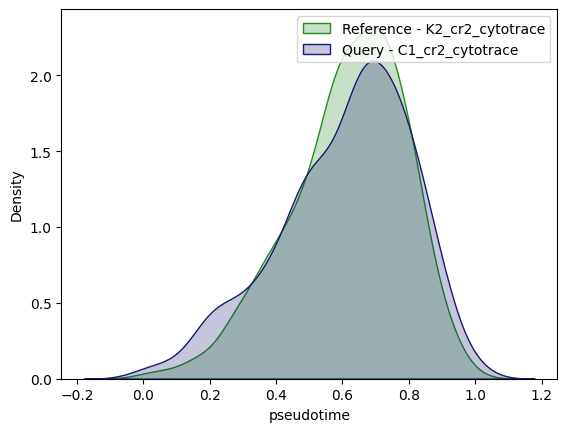

In [8]:
# Visualize the pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label=f'Reference - {prefix_ref}', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label=f'Query - {prefix_query}', color='midnightblue'); 
plt.xlabel('pseudotime'); plt.legend()
plt.savefig(f'pseudotime_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')
plt.show()
plt.close('all')

### Determine the number of discrete pseudotime points to align

We can use optbinning package (https://gnpalencia.org/optbinning/installation.html) to get a heuristic estimate about the number of discrete time points to consider by running below on each dataset.<br>  **Note:** Run `pip install optbinning` if this is not already installed. 

In [9]:
from optbinning import ContinuousOptimalBinning

x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))
n_bins = len(optb.splits) # Bins of Reference as a standard

x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

(CVXPY) Aug 13 04:14:10 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


(CVXPY) Aug 13 04:14:10 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


14


12


Accordingly, we go with `n_bins=14`

### Define which cell type annotations and color scheme to use for visualization purposes

`annotation_colname` and `joint_cmap`

In [10]:
# # define annotation column name in the adata obs
# annotation_colname = 'leiden_res_0.50' 
# # adata_ref.obs[annotation_colname] = [x.split('_')[1] for x in adata_ref.obs_names] 
# # adata_query.obs[annotation_colname] = [x.split('_')[1] for x in adata_query.obs_names] 

# # define the joint colormap to use for both reference and query
# col = np.array(sb.color_palette('colorblind'))[range(4)]
# joint_cmap={'1h':col[0], '2h':col[1] , '4h':col[2] , '6h':col[3]}

Inspect the cell type compositions around each discrete pseudotime point (x-axis) to see if it reasonably represents the entire trajectory of interest. 

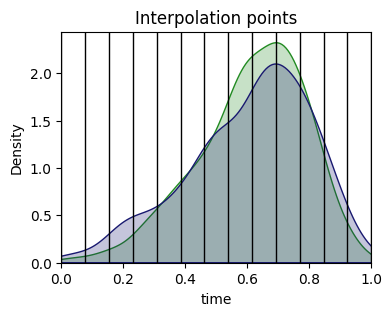

In [11]:
VisualUtils.plot_pseudotime_dists_with_interpolation_points(adata_ref, adata_query, n_bins)
plt.savefig(f'pseudotime_point_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

In [12]:
plt.close('all')

In [13]:
# n_bins = 14
# VisualUtils.plot_celltype_barplot(adata_ref, n_bins, annotation_colname, joint_cmap)
# VisualUtils.plot_celltype_barplot(adata_query, n_bins, annotation_colname, joint_cmap)

## 2. G2G trajectory alignment

**Example gene sets to align:** all human transcription factors, all highly variable genes, lineage-specific genes of interest, a specific pathway gene set etc.

In [14]:
# define the gene list to align 必须两者都存在的基因
hv_ref   = adata_ref.var_names[adata_ref.var['highly_variable']]
hv_query = adata_query.var_names[adata_query.var['highly_variable']]
common_genes = hv_ref.intersection(hv_query)
gene_list = common_genes

print(len(gene_list),'genes')

1754 genes


### Aligning all genes

In [15]:
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins) #
aligner.align_all_pairs() 

Genes2Genes (v0.2.0)
Dynamic programming alignment of gene pseudotime trajectories using a bayesian information-theoretic framework


Interpolator initialization completed
Aligner initialised to align trajectories of 537 reference cells & 409 query cells in terms of 1754 genes
Running gene-level alignment: 🧬


  0%|                                                                                                                                           | 0/1754 [00:00<?, ?it/s]

  0%|                                                                                                                                   | 1/1754 [00:00<09:02,  3.23it/s]

  0%|▏                                                                                                                                  | 2/1754 [00:00<08:01,  3.64it/s]

  0%|▏                                                                                                                                  | 3/1754 [00:00<08:00,  3.64it/s]

  0%|▎                                                                                                                                  | 4/1754 [00:01<07:23,  3.94it/s]

  0%|▎                                                                                                                                  | 5/1754 [00:01<07:38,  3.82it/s]

  0%|▍                                                                                                                                  | 6/1754 [00:01<07:37,  3.82it/s]

  0%|▌                                                                                                                                  | 7/1754 [00:01<07:48,  3.73it/s]

  0%|▌                                                                                                                                  | 8/1754 [00:02<07:57,  3.66it/s]

  1%|▋                                                                                                                                  | 9/1754 [00:02<07:43,  3.76it/s]

  1%|▋                                                                                                                                 | 10/1754 [00:02<07:34,  3.83it/s]

  1%|▊                                                                                                                                 | 11/1754 [00:02<07:29,  3.88it/s]

  1%|▉                                                                                                                                 | 12/1754 [00:03<07:40,  3.78it/s]

  1%|▉                                                                                                                                 | 13/1754 [00:03<07:17,  3.98it/s]

  1%|█                                                                                                                                 | 14/1754 [00:03<07:16,  3.98it/s]

  1%|█                                                                                                                                 | 15/1754 [00:03<07:32,  3.84it/s]

  1%|█▏                                                                                                                                | 16/1754 [00:04<07:47,  3.71it/s]

  1%|█▎                                                                                                                                | 17/1754 [00:04<07:53,  3.67it/s]

  1%|█▎                                                                                                                                | 18/1754 [00:04<09:28,  3.05it/s]

  1%|█▍                                                                                                                                | 19/1754 [00:05<09:03,  3.20it/s]

  1%|█▍                                                                                                                                | 20/1754 [00:05<08:50,  3.27it/s]

  1%|█▌                                                                                                                                | 21/1754 [00:05<08:42,  3.32it/s]

  1%|█▋                                                                                                                                | 22/1754 [00:06<08:31,  3.39it/s]

  1%|█▋                                                                                                                                | 23/1754 [00:06<08:24,  3.43it/s]

  1%|█▊                                                                                                                                | 24/1754 [00:06<08:19,  3.47it/s]

  1%|█▊                                                                                                                                | 25/1754 [00:06<08:04,  3.57it/s]

  1%|█▉                                                                                                                                | 26/1754 [00:07<07:48,  3.69it/s]

  2%|██                                                                                                                                | 27/1754 [00:07<07:57,  3.62it/s]

  2%|██                                                                                                                                | 28/1754 [00:07<07:55,  3.63it/s]

  2%|██▏                                                                                                                               | 29/1754 [00:07<07:41,  3.74it/s]

  2%|██▏                                                                                                                               | 30/1754 [00:08<07:47,  3.69it/s]

  2%|██▎                                                                                                                               | 31/1754 [00:08<07:46,  3.69it/s]

  2%|██▎                                                                                                                               | 32/1754 [00:08<07:22,  3.89it/s]

  2%|██▍                                                                                                                               | 33/1754 [00:09<07:31,  3.81it/s]

  2%|██▌                                                                                                                               | 34/1754 [00:09<07:24,  3.87it/s]

  2%|██▌                                                                                                                               | 35/1754 [00:09<07:32,  3.80it/s]

  2%|██▋                                                                                                                               | 36/1754 [00:09<07:11,  3.99it/s]

  2%|██▋                                                                                                                               | 37/1754 [00:10<07:30,  3.81it/s]

  2%|██▊                                                                                                                               | 38/1754 [00:10<07:30,  3.81it/s]

  2%|██▉                                                                                                                               | 39/1754 [00:10<07:49,  3.65it/s]

  2%|██▉                                                                                                                               | 40/1754 [00:10<07:54,  3.62it/s]

  2%|███                                                                                                                               | 41/1754 [00:11<07:40,  3.72it/s]

  2%|███                                                                                                                               | 42/1754 [00:11<07:44,  3.69it/s]

  2%|███▏                                                                                                                              | 43/1754 [00:11<07:49,  3.65it/s]

  3%|███▎                                                                                                                              | 44/1754 [00:12<07:57,  3.58it/s]

  3%|███▎                                                                                                                              | 45/1754 [00:12<07:55,  3.59it/s]

  3%|███▍                                                                                                                              | 46/1754 [00:12<07:27,  3.82it/s]

  3%|███▍                                                                                                                              | 47/1754 [00:12<07:34,  3.76it/s]

  3%|███▌                                                                                                                              | 48/1754 [00:13<07:44,  3.67it/s]

  3%|███▋                                                                                                                              | 49/1754 [00:13<07:52,  3.61it/s]

  3%|███▋                                                                                                                              | 50/1754 [00:13<07:54,  3.59it/s]

  3%|███▊                                                                                                                              | 51/1754 [00:13<07:51,  3.61it/s]

  3%|███▊                                                                                                                              | 52/1754 [00:14<07:37,  3.72it/s]

  3%|███▉                                                                                                                              | 53/1754 [00:14<07:48,  3.63it/s]

  3%|████                                                                                                                              | 54/1754 [00:14<07:54,  3.58it/s]

  3%|████                                                                                                                              | 55/1754 [00:15<07:39,  3.70it/s]

  3%|████▏                                                                                                                             | 56/1754 [00:15<07:28,  3.79it/s]

  3%|████▏                                                                                                                             | 57/1754 [00:15<07:42,  3.67it/s]

  3%|████▎                                                                                                                             | 58/1754 [00:15<07:48,  3.62it/s]

  3%|████▎                                                                                                                             | 59/1754 [00:16<07:49,  3.61it/s]

  3%|████▍                                                                                                                             | 60/1754 [00:16<07:21,  3.84it/s]

  3%|████▌                                                                                                                             | 61/1754 [00:16<07:24,  3.81it/s]

  4%|████▌                                                                                                                             | 62/1754 [00:16<07:40,  3.68it/s]

  4%|████▋                                                                                                                             | 63/1754 [00:17<07:44,  3.64it/s]

  4%|████▋                                                                                                                             | 64/1754 [00:17<07:31,  3.75it/s]

  4%|████▊                                                                                                                             | 65/1754 [00:17<07:21,  3.82it/s]

  4%|████▉                                                                                                                             | 66/1754 [00:18<09:13,  3.05it/s]

  4%|████▉                                                                                                                             | 67/1754 [00:18<08:46,  3.21it/s]

  4%|█████                                                                                                                             | 68/1754 [00:18<08:28,  3.31it/s]

  4%|█████                                                                                                                             | 69/1754 [00:19<08:24,  3.34it/s]

  4%|█████▏                                                                                                                            | 70/1754 [00:19<08:00,  3.51it/s]

  4%|█████▎                                                                                                                            | 71/1754 [00:19<08:03,  3.48it/s]

  4%|█████▎                                                                                                                            | 72/1754 [00:19<08:02,  3.49it/s]

  4%|█████▍                                                                                                                            | 73/1754 [00:20<07:59,  3.51it/s]

  4%|█████▍                                                                                                                            | 74/1754 [00:20<07:58,  3.51it/s]

  4%|█████▌                                                                                                                            | 75/1754 [00:20<07:53,  3.54it/s]

  4%|█████▋                                                                                                                            | 76/1754 [00:20<07:23,  3.78it/s]

  4%|█████▋                                                                                                                            | 77/1754 [00:21<07:38,  3.66it/s]

  4%|█████▊                                                                                                                            | 78/1754 [00:21<07:14,  3.86it/s]

  5%|█████▊                                                                                                                            | 79/1754 [00:21<07:29,  3.72it/s]

  5%|█████▉                                                                                                                            | 80/1754 [00:21<07:18,  3.81it/s]

  5%|██████                                                                                                                            | 81/1754 [00:22<07:25,  3.76it/s]

  5%|██████                                                                                                                            | 82/1754 [00:22<07:41,  3.63it/s]

  5%|██████▏                                                                                                                           | 83/1754 [00:22<07:26,  3.74it/s]

  5%|██████▏                                                                                                                           | 84/1754 [00:23<07:21,  3.79it/s]

  5%|██████▎                                                                                                                           | 85/1754 [00:23<07:29,  3.71it/s]

  5%|██████▎                                                                                                                           | 86/1754 [00:23<07:45,  3.58it/s]

  5%|██████▍                                                                                                                           | 87/1754 [00:23<07:20,  3.79it/s]

  5%|██████▌                                                                                                                           | 88/1754 [00:24<07:01,  3.95it/s]

  5%|██████▌                                                                                                                           | 89/1754 [00:24<06:58,  3.97it/s]

  5%|██████▋                                                                                                                           | 90/1754 [00:24<07:11,  3.86it/s]

  5%|██████▋                                                                                                                           | 91/1754 [00:24<06:52,  4.03it/s]

  5%|██████▊                                                                                                                           | 92/1754 [00:25<07:06,  3.90it/s]

  5%|██████▉                                                                                                                           | 93/1754 [00:25<06:48,  4.07it/s]

  5%|██████▉                                                                                                                           | 94/1754 [00:25<06:37,  4.18it/s]

  5%|███████                                                                                                                           | 95/1754 [00:25<07:04,  3.91it/s]

  5%|███████                                                                                                                           | 96/1754 [00:26<07:14,  3.81it/s]

  6%|███████▏                                                                                                                          | 97/1754 [00:26<07:23,  3.73it/s]

  6%|███████▎                                                                                                                          | 98/1754 [00:26<07:30,  3.68it/s]

  6%|███████▎                                                                                                                          | 99/1754 [00:26<07:04,  3.90it/s]

  6%|███████▎                                                                                                                         | 100/1754 [00:27<07:11,  3.83it/s]

  6%|███████▍                                                                                                                         | 101/1754 [00:27<06:51,  4.02it/s]

  6%|███████▌                                                                                                                         | 102/1754 [00:27<06:37,  4.15it/s]

  6%|███████▌                                                                                                                         | 103/1754 [00:27<06:57,  3.96it/s]

  6%|███████▋                                                                                                                         | 104/1754 [00:28<06:42,  4.10it/s]

  6%|███████▋                                                                                                                         | 105/1754 [00:28<06:43,  4.08it/s]

  6%|███████▊                                                                                                                         | 106/1754 [00:28<07:00,  3.92it/s]

  6%|███████▊                                                                                                                         | 107/1754 [00:28<06:50,  4.02it/s]

  6%|███████▉                                                                                                                         | 108/1754 [00:29<06:49,  4.02it/s]

  6%|████████                                                                                                                         | 109/1754 [00:29<07:09,  3.83it/s]

  6%|████████                                                                                                                         | 110/1754 [00:29<07:07,  3.84it/s]

  6%|████████▏                                                                                                                        | 111/1754 [00:29<06:48,  4.02it/s]

  6%|████████▏                                                                                                                        | 112/1754 [00:30<06:36,  4.14it/s]

  6%|████████▎                                                                                                                        | 113/1754 [00:30<06:39,  4.11it/s]

  6%|████████▍                                                                                                                        | 114/1754 [00:30<07:05,  3.86it/s]

  7%|████████▍                                                                                                                        | 115/1754 [00:30<07:15,  3.77it/s]

  7%|████████▌                                                                                                                        | 116/1754 [00:31<07:19,  3.73it/s]

  7%|████████▌                                                                                                                        | 117/1754 [00:31<07:11,  3.79it/s]

  7%|████████▋                                                                                                                        | 118/1754 [00:31<07:18,  3.73it/s]

  7%|████████▊                                                                                                                        | 119/1754 [00:31<06:55,  3.93it/s]

  7%|████████▊                                                                                                                        | 120/1754 [00:32<07:05,  3.84it/s]

  7%|████████▉                                                                                                                        | 121/1754 [00:32<07:17,  3.73it/s]

  7%|████████▉                                                                                                                        | 122/1754 [00:32<07:09,  3.80it/s]

  7%|█████████                                                                                                                        | 123/1754 [00:33<07:23,  3.68it/s]

  7%|█████████                                                                                                                        | 124/1754 [00:33<07:23,  3.67it/s]

  7%|█████████▏                                                                                                                       | 125/1754 [00:33<07:33,  3.59it/s]

  7%|█████████▎                                                                                                                       | 126/1754 [00:33<07:31,  3.61it/s]

  7%|█████████▎                                                                                                                       | 127/1754 [00:34<08:58,  3.02it/s]

  7%|█████████▍                                                                                                                       | 128/1754 [00:34<08:19,  3.26it/s]

  7%|█████████▍                                                                                                                       | 129/1754 [00:34<07:37,  3.55it/s]

  7%|█████████▌                                                                                                                       | 130/1754 [00:35<07:36,  3.56it/s]

  7%|█████████▋                                                                                                                       | 131/1754 [00:35<07:40,  3.53it/s]

  8%|█████████▋                                                                                                                       | 132/1754 [00:35<07:50,  3.45it/s]

  8%|█████████▊                                                                                                                       | 133/1754 [00:36<07:45,  3.48it/s]

  8%|█████████▊                                                                                                                       | 134/1754 [00:36<07:31,  3.59it/s]

  8%|█████████▉                                                                                                                       | 135/1754 [00:36<07:42,  3.50it/s]

  8%|██████████                                                                                                                       | 136/1754 [00:36<07:29,  3.60it/s]

  8%|██████████                                                                                                                       | 137/1754 [00:37<07:03,  3.82it/s]

  8%|██████████▏                                                                                                                      | 138/1754 [00:37<06:44,  4.00it/s]

  8%|██████████▏                                                                                                                      | 139/1754 [00:37<06:32,  4.12it/s]

  8%|██████████▎                                                                                                                      | 140/1754 [00:37<06:35,  4.08it/s]

  8%|██████████▎                                                                                                                      | 141/1754 [00:38<06:50,  3.93it/s]

  8%|██████████▍                                                                                                                      | 142/1754 [00:38<06:36,  4.06it/s]

  8%|██████████▌                                                                                                                      | 143/1754 [00:38<06:55,  3.88it/s]

  8%|██████████▌                                                                                                                      | 144/1754 [00:38<06:54,  3.88it/s]

  8%|██████████▋                                                                                                                      | 145/1754 [00:39<07:07,  3.76it/s]

  8%|██████████▋                                                                                                                      | 146/1754 [00:39<07:13,  3.71it/s]

  8%|██████████▊                                                                                                                      | 147/1754 [00:39<07:20,  3.65it/s]

  8%|██████████▉                                                                                                                      | 148/1754 [00:39<07:28,  3.58it/s]

  8%|██████████▉                                                                                                                      | 149/1754 [00:40<07:35,  3.52it/s]

  9%|███████████                                                                                                                      | 150/1754 [00:40<07:05,  3.77it/s]

  9%|███████████                                                                                                                      | 151/1754 [00:40<06:59,  3.82it/s]

  9%|███████████▏                                                                                                                     | 152/1754 [00:40<07:14,  3.69it/s]

  9%|███████████▎                                                                                                                     | 153/1754 [00:41<07:27,  3.58it/s]

  9%|███████████▎                                                                                                                     | 154/1754 [00:41<07:30,  3.55it/s]

  9%|███████████▍                                                                                                                     | 155/1754 [00:41<07:13,  3.68it/s]

  9%|███████████▍                                                                                                                     | 156/1754 [00:42<07:02,  3.78it/s]

  9%|███████████▌                                                                                                                     | 157/1754 [00:42<06:55,  3.85it/s]

  9%|███████████▌                                                                                                                     | 158/1754 [00:42<06:49,  3.90it/s]

  9%|███████████▋                                                                                                                     | 159/1754 [00:42<06:32,  4.06it/s]

  9%|███████████▊                                                                                                                     | 160/1754 [00:43<06:48,  3.91it/s]

  9%|███████████▊                                                                                                                     | 161/1754 [00:43<06:43,  3.94it/s]

  9%|███████████▉                                                                                                                     | 162/1754 [00:43<06:59,  3.80it/s]

  9%|███████████▉                                                                                                                     | 163/1754 [00:43<06:56,  3.82it/s]

  9%|████████████                                                                                                                     | 164/1754 [00:44<06:55,  3.83it/s]

  9%|████████████▏                                                                                                                    | 165/1754 [00:44<07:03,  3.75it/s]

  9%|████████████▏                                                                                                                    | 166/1754 [00:44<07:07,  3.71it/s]

 10%|████████████▎                                                                                                                    | 167/1754 [00:44<07:09,  3.69it/s]

 10%|████████████▎                                                                                                                    | 168/1754 [00:45<07:15,  3.65it/s]

 10%|████████████▍                                                                                                                    | 169/1754 [00:45<07:02,  3.75it/s]

 10%|████████████▌                                                                                                                    | 170/1754 [00:45<06:41,  3.95it/s]

 10%|████████████▌                                                                                                                    | 171/1754 [00:45<06:50,  3.86it/s]

 10%|████████████▋                                                                                                                    | 172/1754 [00:46<07:04,  3.73it/s]

 10%|████████████▋                                                                                                                    | 173/1754 [00:46<06:44,  3.91it/s]

 10%|████████████▊                                                                                                                    | 174/1754 [00:46<06:45,  3.90it/s]

 10%|████████████▊                                                                                                                    | 175/1754 [00:47<06:59,  3.76it/s]

 10%|████████████▉                                                                                                                    | 176/1754 [00:47<07:18,  3.60it/s]

 10%|█████████████                                                                                                                    | 177/1754 [00:47<07:07,  3.69it/s]

 10%|█████████████                                                                                                                    | 178/1754 [00:47<06:57,  3.78it/s]

 10%|█████████████▏                                                                                                                   | 179/1754 [00:48<07:00,  3.74it/s]

 10%|█████████████▏                                                                                                                   | 180/1754 [00:48<07:08,  3.67it/s]

 10%|█████████████▎                                                                                                                   | 181/1754 [00:48<07:16,  3.60it/s]

 10%|█████████████▍                                                                                                                   | 182/1754 [00:48<06:52,  3.81it/s]

 10%|█████████████▍                                                                                                                   | 183/1754 [00:49<06:34,  3.98it/s]

 10%|█████████████▌                                                                                                                   | 184/1754 [00:49<06:56,  3.77it/s]

 11%|█████████████▌                                                                                                                   | 185/1754 [00:49<07:03,  3.71it/s]

 11%|█████████████▋                                                                                                                   | 186/1754 [00:50<07:08,  3.66it/s]

 11%|█████████████▊                                                                                                                   | 187/1754 [00:50<06:58,  3.74it/s]

 11%|█████████████▊                                                                                                                   | 188/1754 [00:50<07:08,  3.66it/s]

 11%|█████████████▉                                                                                                                   | 189/1754 [00:50<06:55,  3.76it/s]

 11%|█████████████▉                                                                                                                   | 190/1754 [00:51<06:59,  3.73it/s]

 11%|██████████████                                                                                                                   | 191/1754 [00:51<07:09,  3.64it/s]

 11%|██████████████                                                                                                                   | 192/1754 [00:51<06:44,  3.87it/s]

 11%|██████████████▏                                                                                                                  | 193/1754 [00:51<06:39,  3.91it/s]

 11%|██████████████▎                                                                                                                  | 194/1754 [00:52<06:36,  3.94it/s]

 11%|██████████████▎                                                                                                                  | 195/1754 [00:52<06:42,  3.87it/s]

 11%|██████████████▍                                                                                                                  | 196/1754 [00:52<06:54,  3.76it/s]

 11%|██████████████▍                                                                                                                  | 197/1754 [00:52<06:46,  3.83it/s]

 11%|██████████████▌                                                                                                                  | 198/1754 [00:53<06:41,  3.87it/s]

 11%|██████████████▋                                                                                                                  | 199/1754 [00:53<06:37,  3.91it/s]

 11%|██████████████▋                                                                                                                  | 200/1754 [00:53<06:45,  3.83it/s]

 11%|██████████████▊                                                                                                                  | 201/1754 [00:53<06:41,  3.87it/s]

 12%|██████████████▊                                                                                                                  | 202/1754 [00:54<06:57,  3.72it/s]

 12%|██████████████▉                                                                                                                  | 203/1754 [00:54<08:59,  2.88it/s]

 12%|███████████████                                                                                                                  | 204/1754 [00:55<08:28,  3.05it/s]

 12%|███████████████                                                                                                                  | 205/1754 [00:55<07:38,  3.38it/s]

 12%|███████████████▏                                                                                                                 | 206/1754 [00:55<07:33,  3.41it/s]

 12%|███████████████▏                                                                                                                 | 207/1754 [00:55<07:25,  3.47it/s]

 12%|███████████████▎                                                                                                                 | 208/1754 [00:56<07:21,  3.50it/s]

 12%|███████████████▎                                                                                                                 | 209/1754 [00:56<06:54,  3.73it/s]

 12%|███████████████▍                                                                                                                 | 210/1754 [00:56<06:36,  3.89it/s]

 12%|███████████████▌                                                                                                                 | 211/1754 [00:56<06:21,  4.04it/s]

 12%|███████████████▌                                                                                                                 | 212/1754 [00:57<06:38,  3.87it/s]

 12%|███████████████▋                                                                                                                 | 213/1754 [00:57<06:27,  3.98it/s]

 12%|███████████████▋                                                                                                                 | 214/1754 [00:57<06:39,  3.86it/s]

 12%|███████████████▊                                                                                                                 | 215/1754 [00:57<06:46,  3.79it/s]

 12%|███████████████▉                                                                                                                 | 216/1754 [00:58<06:56,  3.69it/s]

 12%|███████████████▉                                                                                                                 | 217/1754 [00:58<07:01,  3.65it/s]

 12%|████████████████                                                                                                                 | 218/1754 [00:58<07:01,  3.64it/s]

 12%|████████████████                                                                                                                 | 219/1754 [00:58<06:37,  3.86it/s]

 13%|████████████████▏                                                                                                                | 220/1754 [00:59<06:50,  3.73it/s]

 13%|████████████████▎                                                                                                                | 221/1754 [00:59<06:41,  3.82it/s]

 13%|████████████████▎                                                                                                                | 222/1754 [00:59<06:23,  4.00it/s]

 13%|████████████████▍                                                                                                                | 223/1754 [00:59<06:39,  3.83it/s]

 13%|████████████████▍                                                                                                                | 224/1754 [01:00<06:49,  3.74it/s]

 13%|████████████████▌                                                                                                                | 225/1754 [01:00<06:41,  3.81it/s]

 13%|████████████████▌                                                                                                                | 226/1754 [01:00<06:23,  3.99it/s]

 13%|████████████████▋                                                                                                                | 227/1754 [01:00<06:09,  4.13it/s]

 13%|████████████████▊                                                                                                                | 228/1754 [01:01<06:25,  3.96it/s]

 13%|████████████████▊                                                                                                                | 229/1754 [01:01<06:24,  3.97it/s]

 13%|████████████████▉                                                                                                                | 230/1754 [01:01<06:36,  3.84it/s]

 13%|████████████████▉                                                                                                                | 231/1754 [01:02<06:46,  3.75it/s]

 13%|█████████████████                                                                                                                | 232/1754 [01:02<06:38,  3.82it/s]

 13%|█████████████████▏                                                                                                               | 233/1754 [01:02<06:40,  3.80it/s]

 13%|█████████████████▏                                                                                                               | 234/1754 [01:02<06:33,  3.87it/s]

 13%|█████████████████▎                                                                                                               | 235/1754 [01:03<06:32,  3.87it/s]

 13%|█████████████████▎                                                                                                               | 236/1754 [01:03<06:15,  4.05it/s]

 14%|█████████████████▍                                                                                                               | 237/1754 [01:03<06:02,  4.18it/s]

 14%|█████████████████▌                                                                                                               | 238/1754 [01:03<06:21,  3.97it/s]

 14%|█████████████████▌                                                                                                               | 239/1754 [01:04<06:20,  3.99it/s]

 14%|█████████████████▋                                                                                                               | 240/1754 [01:04<06:37,  3.81it/s]

 14%|█████████████████▋                                                                                                               | 241/1754 [01:04<06:18,  3.99it/s]

 14%|█████████████████▊                                                                                                               | 242/1754 [01:04<06:17,  4.01it/s]

 14%|█████████████████▊                                                                                                               | 243/1754 [01:05<06:16,  4.02it/s]

 14%|█████████████████▉                                                                                                               | 244/1754 [01:05<06:16,  4.01it/s]

 14%|██████████████████                                                                                                               | 245/1754 [01:05<06:03,  4.15it/s]

 14%|██████████████████                                                                                                               | 246/1754 [01:05<05:58,  4.20it/s]

 14%|██████████████████▏                                                                                                              | 247/1754 [01:06<06:16,  4.01it/s]

 14%|██████████████████▏                                                                                                              | 248/1754 [01:06<06:27,  3.89it/s]

 14%|██████████████████▎                                                                                                              | 249/1754 [01:06<06:36,  3.80it/s]

 14%|██████████████████▍                                                                                                              | 250/1754 [01:06<06:36,  3.79it/s]

 14%|██████████████████▍                                                                                                              | 251/1754 [01:07<06:31,  3.84it/s]

 14%|██████████████████▌                                                                                                              | 252/1754 [01:07<06:44,  3.72it/s]

 14%|██████████████████▌                                                                                                              | 253/1754 [01:07<06:36,  3.78it/s]

 14%|██████████████████▋                                                                                                              | 254/1754 [01:07<06:29,  3.85it/s]

 15%|██████████████████▊                                                                                                              | 255/1754 [01:08<06:40,  3.74it/s]

 15%|██████████████████▊                                                                                                              | 256/1754 [01:08<06:46,  3.68it/s]

 15%|██████████████████▉                                                                                                              | 257/1754 [01:08<06:32,  3.81it/s]

 15%|██████████████████▉                                                                                                              | 258/1754 [01:08<06:36,  3.77it/s]

 15%|███████████████████                                                                                                              | 259/1754 [01:09<06:40,  3.73it/s]

 15%|███████████████████                                                                                                              | 260/1754 [01:09<06:50,  3.64it/s]

 15%|███████████████████▏                                                                                                             | 261/1754 [01:09<06:53,  3.61it/s]

 15%|███████████████████▎                                                                                                             | 262/1754 [01:10<06:54,  3.60it/s]

 15%|███████████████████▎                                                                                                             | 263/1754 [01:10<06:33,  3.78it/s]

 15%|███████████████████▍                                                                                                             | 264/1754 [01:10<06:26,  3.85it/s]

 15%|███████████████████▍                                                                                                             | 265/1754 [01:10<06:35,  3.76it/s]

 15%|███████████████████▌                                                                                                             | 266/1754 [01:11<06:45,  3.67it/s]

 15%|███████████████████▋                                                                                                             | 267/1754 [01:11<06:35,  3.76it/s]

 15%|███████████████████▋                                                                                                             | 268/1754 [01:11<06:15,  3.96it/s]

 15%|███████████████████▊                                                                                                             | 269/1754 [01:11<06:19,  3.92it/s]

 15%|███████████████████▊                                                                                                             | 270/1754 [01:12<06:33,  3.78it/s]

 15%|███████████████████▉                                                                                                             | 271/1754 [01:12<06:45,  3.66it/s]

 16%|████████████████████                                                                                                             | 272/1754 [01:12<06:43,  3.67it/s]

 16%|████████████████████                                                                                                             | 273/1754 [01:12<06:32,  3.77it/s]

 16%|████████████████████▏                                                                                                            | 274/1754 [01:13<06:25,  3.84it/s]

 16%|████████████████████▏                                                                                                            | 275/1754 [01:13<06:23,  3.86it/s]

 16%|████████████████████▎                                                                                                            | 276/1754 [01:13<06:32,  3.77it/s]

 16%|████████████████████▎                                                                                                            | 277/1754 [01:13<06:30,  3.78it/s]

 16%|████████████████████▍                                                                                                            | 278/1754 [01:14<06:36,  3.72it/s]

 16%|████████████████████▌                                                                                                            | 279/1754 [01:14<06:15,  3.92it/s]

 16%|████████████████████▌                                                                                                            | 280/1754 [01:14<06:05,  4.03it/s]

 16%|████████████████████▋                                                                                                            | 281/1754 [01:14<06:05,  4.03it/s]

 16%|████████████████████▋                                                                                                            | 282/1754 [01:15<06:21,  3.86it/s]

 16%|████████████████████▊                                                                                                            | 283/1754 [01:15<06:20,  3.87it/s]

 16%|████████████████████▉                                                                                                            | 284/1754 [01:15<06:31,  3.76it/s]

 16%|████████████████████▉                                                                                                            | 285/1754 [01:16<06:13,  3.94it/s]

 16%|█████████████████████                                                                                                            | 286/1754 [01:16<06:31,  3.75it/s]

 16%|█████████████████████                                                                                                            | 287/1754 [01:16<06:13,  3.92it/s]

 16%|█████████████████████▏                                                                                                           | 288/1754 [01:16<06:28,  3.77it/s]

 16%|█████████████████████▎                                                                                                           | 289/1754 [01:17<06:11,  3.94it/s]

 17%|█████████████████████▎                                                                                                           | 290/1754 [01:17<06:01,  4.05it/s]

 17%|█████████████████████▍                                                                                                           | 291/1754 [01:17<06:11,  3.93it/s]

 17%|█████████████████████▍                                                                                                           | 292/1754 [01:17<06:32,  3.72it/s]

 17%|█████████████████████▌                                                                                                           | 293/1754 [01:18<06:12,  3.92it/s]

 17%|█████████████████████▌                                                                                                           | 294/1754 [01:18<06:22,  3.81it/s]

 17%|█████████████████████▋                                                                                                           | 295/1754 [01:18<08:45,  2.78it/s]

 17%|█████████████████████▊                                                                                                           | 296/1754 [01:19<08:13,  2.95it/s]

 17%|█████████████████████▊                                                                                                           | 297/1754 [01:19<07:34,  3.20it/s]

 17%|█████████████████████▉                                                                                                           | 298/1754 [01:19<06:54,  3.51it/s]

 17%|█████████████████████▉                                                                                                           | 299/1754 [01:20<06:49,  3.55it/s]

 17%|██████████████████████                                                                                                           | 300/1754 [01:20<06:34,  3.69it/s]

 17%|██████████████████████▏                                                                                                          | 301/1754 [01:20<06:35,  3.68it/s]

 17%|██████████████████████▏                                                                                                          | 302/1754 [01:20<06:40,  3.63it/s]

 17%|██████████████████████▎                                                                                                          | 303/1754 [01:21<06:31,  3.70it/s]

 17%|██████████████████████▎                                                                                                          | 304/1754 [01:21<06:42,  3.60it/s]

 17%|██████████████████████▍                                                                                                          | 305/1754 [01:21<06:33,  3.68it/s]

 17%|██████████████████████▌                                                                                                          | 306/1754 [01:21<06:14,  3.86it/s]

 18%|██████████████████████▌                                                                                                          | 307/1754 [01:22<06:14,  3.87it/s]

 18%|██████████████████████▋                                                                                                          | 308/1754 [01:22<06:02,  3.99it/s]

 18%|██████████████████████▋                                                                                                          | 309/1754 [01:22<06:12,  3.87it/s]

 18%|██████████████████████▊                                                                                                          | 310/1754 [01:22<06:08,  3.92it/s]

 18%|██████████████████████▊                                                                                                          | 311/1754 [01:23<06:16,  3.83it/s]

 18%|██████████████████████▉                                                                                                          | 312/1754 [01:23<06:28,  3.71it/s]

 18%|███████████████████████                                                                                                          | 313/1754 [01:23<06:35,  3.65it/s]

 18%|███████████████████████                                                                                                          | 314/1754 [01:23<06:33,  3.66it/s]

 18%|███████████████████████▏                                                                                                         | 315/1754 [01:24<06:24,  3.74it/s]

 18%|███████████████████████▏                                                                                                         | 316/1754 [01:24<06:39,  3.60it/s]

 18%|███████████████████████▎                                                                                                         | 317/1754 [01:24<06:26,  3.72it/s]

 18%|███████████████████████▍                                                                                                         | 318/1754 [01:25<06:16,  3.81it/s]

 18%|███████████████████████▍                                                                                                         | 319/1754 [01:25<06:09,  3.89it/s]

 18%|███████████████████████▌                                                                                                         | 320/1754 [01:25<06:25,  3.72it/s]

 18%|███████████████████████▌                                                                                                         | 321/1754 [01:25<06:15,  3.81it/s]

 18%|███████████████████████▋                                                                                                         | 322/1754 [01:26<05:57,  4.00it/s]

 18%|███████████████████████▊                                                                                                         | 323/1754 [01:26<05:46,  4.13it/s]

 18%|███████████████████████▊                                                                                                         | 324/1754 [01:26<05:56,  4.01it/s]

 19%|███████████████████████▉                                                                                                         | 325/1754 [01:26<06:08,  3.87it/s]

 19%|███████████████████████▉                                                                                                         | 326/1754 [01:27<06:19,  3.76it/s]

 19%|████████████████████████                                                                                                         | 327/1754 [01:27<06:26,  3.69it/s]

 19%|████████████████████████                                                                                                         | 328/1754 [01:27<06:28,  3.67it/s]

 19%|████████████████████████▏                                                                                                        | 329/1754 [01:27<06:17,  3.77it/s]

 19%|████████████████████████▎                                                                                                        | 330/1754 [01:28<06:22,  3.72it/s]

 19%|████████████████████████▎                                                                                                        | 331/1754 [01:28<06:02,  3.92it/s]

 19%|████████████████████████▍                                                                                                        | 332/1754 [01:28<06:19,  3.75it/s]

 19%|████████████████████████▍                                                                                                        | 333/1754 [01:28<06:00,  3.95it/s]

 19%|████████████████████████▌                                                                                                        | 334/1754 [01:29<06:08,  3.85it/s]

 19%|████████████████████████▋                                                                                                        | 335/1754 [01:29<05:52,  4.03it/s]

 19%|████████████████████████▋                                                                                                        | 336/1754 [01:29<06:04,  3.89it/s]

 19%|████████████████████████▊                                                                                                        | 337/1754 [01:29<06:00,  3.93it/s]

 19%|████████████████████████▊                                                                                                        | 338/1754 [01:30<05:48,  4.07it/s]

 19%|████████████████████████▉                                                                                                        | 339/1754 [01:30<05:53,  4.01it/s]

 19%|█████████████████████████                                                                                                        | 340/1754 [01:30<06:06,  3.86it/s]

 19%|█████████████████████████                                                                                                        | 341/1754 [01:30<06:05,  3.87it/s]

 19%|█████████████████████████▏                                                                                                       | 342/1754 [01:31<06:15,  3.76it/s]

 20%|█████████████████████████▏                                                                                                       | 343/1754 [01:31<06:21,  3.70it/s]

 20%|█████████████████████████▎                                                                                                       | 344/1754 [01:31<06:33,  3.59it/s]

 20%|█████████████████████████▎                                                                                                       | 345/1754 [01:32<06:19,  3.71it/s]

 20%|█████████████████████████▍                                                                                                       | 346/1754 [01:32<06:21,  3.69it/s]

 20%|█████████████████████████▌                                                                                                       | 347/1754 [01:32<06:17,  3.73it/s]

 20%|█████████████████████████▌                                                                                                       | 348/1754 [01:32<06:32,  3.58it/s]

 20%|█████████████████████████▋                                                                                                       | 349/1754 [01:33<06:22,  3.67it/s]

 20%|█████████████████████████▋                                                                                                       | 350/1754 [01:33<06:28,  3.62it/s]

 20%|█████████████████████████▊                                                                                                       | 351/1754 [01:33<06:34,  3.55it/s]

 20%|█████████████████████████▉                                                                                                       | 352/1754 [01:33<06:18,  3.71it/s]

 20%|█████████████████████████▉                                                                                                       | 353/1754 [01:34<06:20,  3.68it/s]

 20%|██████████████████████████                                                                                                       | 354/1754 [01:34<06:25,  3.63it/s]

 20%|██████████████████████████                                                                                                       | 355/1754 [01:34<06:30,  3.58it/s]

 20%|██████████████████████████▏                                                                                                      | 356/1754 [01:35<06:35,  3.53it/s]

 20%|██████████████████████████▎                                                                                                      | 357/1754 [01:35<06:09,  3.78it/s]

 20%|██████████████████████████▎                                                                                                      | 358/1754 [01:35<06:19,  3.68it/s]

 20%|██████████████████████████▍                                                                                                      | 359/1754 [01:35<06:11,  3.76it/s]

 21%|██████████████████████████▍                                                                                                      | 360/1754 [01:36<06:04,  3.82it/s]

 21%|██████████████████████████▌                                                                                                      | 361/1754 [01:36<05:59,  3.88it/s]

 21%|██████████████████████████▌                                                                                                      | 362/1754 [01:36<06:06,  3.79it/s]

 21%|██████████████████████████▋                                                                                                      | 363/1754 [01:36<06:21,  3.64it/s]

 21%|██████████████████████████▊                                                                                                      | 364/1754 [01:37<06:31,  3.55it/s]

 21%|██████████████████████████▊                                                                                                      | 365/1754 [01:37<06:37,  3.49it/s]

 21%|██████████████████████████▉                                                                                                      | 366/1754 [01:37<06:32,  3.53it/s]

 21%|██████████████████████████▉                                                                                                      | 367/1754 [01:38<06:18,  3.67it/s]

 21%|███████████████████████████                                                                                                      | 368/1754 [01:38<06:20,  3.64it/s]

 21%|███████████████████████████▏                                                                                                     | 369/1754 [01:38<05:58,  3.86it/s]

 21%|███████████████████████████▏                                                                                                     | 370/1754 [01:38<05:53,  3.91it/s]

 21%|███████████████████████████▎                                                                                                     | 371/1754 [01:39<06:02,  3.81it/s]

 21%|███████████████████████████▎                                                                                                     | 372/1754 [01:39<05:57,  3.87it/s]

 21%|███████████████████████████▍                                                                                                     | 373/1754 [01:39<06:04,  3.79it/s]

 21%|███████████████████████████▌                                                                                                     | 374/1754 [01:39<06:07,  3.75it/s]

 21%|███████████████████████████▌                                                                                                     | 375/1754 [01:40<06:17,  3.66it/s]

 21%|███████████████████████████▋                                                                                                     | 376/1754 [01:40<06:17,  3.65it/s]

 21%|███████████████████████████▋                                                                                                     | 377/1754 [01:40<05:56,  3.87it/s]

 22%|███████████████████████████▊                                                                                                     | 378/1754 [01:40<06:03,  3.78it/s]

 22%|███████████████████████████▊                                                                                                     | 379/1754 [01:41<06:12,  3.69it/s]

 22%|███████████████████████████▉                                                                                                     | 380/1754 [01:41<06:08,  3.73it/s]

 22%|████████████████████████████                                                                                                     | 381/1754 [01:41<06:14,  3.66it/s]

 22%|████████████████████████████                                                                                                     | 382/1754 [01:42<06:21,  3.60it/s]

 22%|████████████████████████████▏                                                                                                    | 383/1754 [01:42<06:19,  3.61it/s]

 22%|████████████████████████████▏                                                                                                    | 384/1754 [01:42<06:07,  3.72it/s]

 22%|████████████████████████████▎                                                                                                    | 385/1754 [01:42<06:04,  3.76it/s]

 22%|████████████████████████████▍                                                                                                    | 386/1754 [01:43<06:07,  3.73it/s]

 22%|████████████████████████████▍                                                                                                    | 387/1754 [01:43<05:48,  3.93it/s]

 22%|████████████████████████████▌                                                                                                    | 388/1754 [01:43<05:58,  3.81it/s]

 22%|████████████████████████████▌                                                                                                    | 389/1754 [01:43<06:09,  3.69it/s]

 22%|████████████████████████████▋                                                                                                    | 390/1754 [01:44<06:18,  3.60it/s]

 22%|████████████████████████████▊                                                                                                    | 391/1754 [01:44<06:18,  3.60it/s]

 22%|████████████████████████████▊                                                                                                    | 392/1754 [01:44<06:23,  3.55it/s]

 22%|████████████████████████████▉                                                                                                    | 393/1754 [01:45<06:20,  3.58it/s]

 22%|████████████████████████████▉                                                                                                    | 394/1754 [01:45<06:08,  3.69it/s]

 23%|█████████████████████████████                                                                                                    | 395/1754 [01:45<05:48,  3.90it/s]

 23%|█████████████████████████████                                                                                                    | 396/1754 [01:45<05:33,  4.07it/s]

 23%|█████████████████████████████▏                                                                                                   | 397/1754 [01:46<05:25,  4.17it/s]

 23%|█████████████████████████████▎                                                                                                   | 398/1754 [01:46<05:35,  4.04it/s]

 23%|█████████████████████████████▎                                                                                                   | 399/1754 [01:46<05:36,  4.03it/s]

 23%|█████████████████████████████▍                                                                                                   | 400/1754 [01:46<05:54,  3.82it/s]

 23%|█████████████████████████████▍                                                                                                   | 401/1754 [01:47<05:51,  3.85it/s]

 23%|█████████████████████████████▌                                                                                                   | 402/1754 [01:47<05:50,  3.86it/s]

 23%|█████████████████████████████▋                                                                                                   | 403/1754 [01:47<05:55,  3.80it/s]

 23%|█████████████████████████████▋                                                                                                   | 404/1754 [01:47<05:56,  3.79it/s]

 23%|█████████████████████████████▊                                                                                                   | 405/1754 [01:48<06:07,  3.67it/s]

 23%|█████████████████████████████▊                                                                                                   | 406/1754 [01:48<05:51,  3.84it/s]

 23%|█████████████████████████████▉                                                                                                   | 407/1754 [01:48<06:03,  3.70it/s]

 23%|██████████████████████████████                                                                                                   | 408/1754 [01:48<06:09,  3.64it/s]

 23%|██████████████████████████████                                                                                                   | 409/1754 [01:49<05:59,  3.74it/s]

 23%|██████████████████████████████▏                                                                                                  | 410/1754 [01:49<06:03,  3.70it/s]

 23%|██████████████████████████████▏                                                                                                  | 411/1754 [01:50<08:12,  2.73it/s]

 23%|██████████████████████████████▎                                                                                                  | 412/1754 [01:50<07:34,  2.95it/s]

 24%|██████████████████████████████▎                                                                                                  | 413/1754 [01:50<06:58,  3.20it/s]

 24%|██████████████████████████████▍                                                                                                  | 414/1754 [01:50<06:45,  3.30it/s]

 24%|██████████████████████████████▌                                                                                                  | 415/1754 [01:51<06:34,  3.39it/s]

 24%|██████████████████████████████▌                                                                                                  | 416/1754 [01:51<06:26,  3.46it/s]

 24%|██████████████████████████████▋                                                                                                  | 417/1754 [01:51<06:25,  3.47it/s]

 24%|██████████████████████████████▋                                                                                                  | 418/1754 [01:51<06:03,  3.67it/s]

 24%|██████████████████████████████▊                                                                                                  | 419/1754 [01:52<06:07,  3.63it/s]

 24%|██████████████████████████████▉                                                                                                  | 420/1754 [01:52<05:45,  3.86it/s]

 24%|██████████████████████████████▉                                                                                                  | 421/1754 [01:52<05:52,  3.78it/s]

 24%|███████████████████████████████                                                                                                  | 422/1754 [01:52<05:35,  3.97it/s]

 24%|███████████████████████████████                                                                                                  | 423/1754 [01:53<05:34,  3.98it/s]

 24%|███████████████████████████████▏                                                                                                 | 424/1754 [01:53<05:37,  3.95it/s]

 24%|███████████████████████████████▎                                                                                                 | 425/1754 [01:53<05:24,  4.10it/s]

 24%|███████████████████████████████▎                                                                                                 | 426/1754 [01:53<05:14,  4.22it/s]

 24%|███████████████████████████████▍                                                                                                 | 427/1754 [01:54<05:25,  4.07it/s]

 24%|███████████████████████████████▍                                                                                                 | 428/1754 [01:54<05:40,  3.89it/s]

 24%|███████████████████████████████▌                                                                                                 | 429/1754 [01:54<05:47,  3.81it/s]

 25%|███████████████████████████████▌                                                                                                 | 430/1754 [01:55<05:45,  3.83it/s]

 25%|███████████████████████████████▋                                                                                                 | 431/1754 [01:55<05:44,  3.84it/s]

 25%|███████████████████████████████▊                                                                                                 | 432/1754 [01:55<05:52,  3.75it/s]

 25%|███████████████████████████████▊                                                                                                 | 433/1754 [01:55<06:00,  3.67it/s]

 25%|███████████████████████████████▉                                                                                                 | 434/1754 [01:56<05:54,  3.72it/s]

 25%|███████████████████████████████▉                                                                                                 | 435/1754 [01:56<05:48,  3.78it/s]

 25%|████████████████████████████████                                                                                                 | 436/1754 [01:56<05:32,  3.97it/s]

 25%|████████████████████████████████▏                                                                                                | 437/1754 [01:56<05:19,  4.12it/s]

 25%|████████████████████████████████▏                                                                                                | 438/1754 [01:57<05:37,  3.90it/s]

 25%|████████████████████████████████▎                                                                                                | 439/1754 [01:57<05:36,  3.91it/s]

 25%|████████████████████████████████▎                                                                                                | 440/1754 [01:57<05:23,  4.06it/s]

 25%|████████████████████████████████▍                                                                                                | 441/1754 [01:57<05:30,  3.97it/s]

 25%|████████████████████████████████▌                                                                                                | 442/1754 [01:58<05:41,  3.84it/s]

 25%|████████████████████████████████▌                                                                                                | 443/1754 [01:58<05:36,  3.89it/s]

 25%|████████████████████████████████▋                                                                                                | 444/1754 [01:58<05:33,  3.93it/s]

 25%|████████████████████████████████▋                                                                                                | 445/1754 [01:58<05:32,  3.94it/s]

 25%|████████████████████████████████▊                                                                                                | 446/1754 [01:59<05:29,  3.96it/s]

 25%|████████████████████████████████▉                                                                                                | 447/1754 [01:59<05:42,  3.81it/s]

 26%|████████████████████████████████▉                                                                                                | 448/1754 [01:59<05:48,  3.74it/s]

 26%|█████████████████████████████████                                                                                                | 449/1754 [01:59<05:30,  3.95it/s]

 26%|█████████████████████████████████                                                                                                | 450/1754 [02:00<05:17,  4.10it/s]

 26%|█████████████████████████████████▏                                                                                               | 451/1754 [02:00<05:37,  3.86it/s]

 26%|█████████████████████████████████▏                                                                                               | 452/1754 [02:00<05:40,  3.83it/s]

 26%|█████████████████████████████████▎                                                                                               | 453/1754 [02:00<05:49,  3.72it/s]

 26%|█████████████████████████████████▍                                                                                               | 454/1754 [02:01<05:41,  3.81it/s]

 26%|█████████████████████████████████▍                                                                                               | 455/1754 [02:01<05:49,  3.72it/s]

 26%|█████████████████████████████████▌                                                                                               | 456/1754 [02:01<05:54,  3.67it/s]

 26%|█████████████████████████████████▌                                                                                               | 457/1754 [02:02<05:57,  3.63it/s]

 26%|█████████████████████████████████▋                                                                                               | 458/1754 [02:02<06:02,  3.57it/s]

 26%|█████████████████████████████████▊                                                                                               | 459/1754 [02:02<05:58,  3.61it/s]

 26%|█████████████████████████████████▊                                                                                               | 460/1754 [02:02<06:04,  3.55it/s]

 26%|█████████████████████████████████▉                                                                                               | 461/1754 [02:03<05:40,  3.79it/s]

 26%|█████████████████████████████████▉                                                                                               | 462/1754 [02:03<05:44,  3.75it/s]

 26%|██████████████████████████████████                                                                                               | 463/1754 [02:03<05:50,  3.68it/s]

 26%|██████████████████████████████████▏                                                                                              | 464/1754 [02:03<05:51,  3.67it/s]

 27%|██████████████████████████████████▏                                                                                              | 465/1754 [02:04<05:31,  3.89it/s]

 27%|██████████████████████████████████▎                                                                                              | 466/1754 [02:04<05:42,  3.76it/s]

 27%|██████████████████████████████████▎                                                                                              | 467/1754 [02:04<05:47,  3.70it/s]

 27%|██████████████████████████████████▍                                                                                              | 468/1754 [02:05<05:52,  3.65it/s]

 27%|██████████████████████████████████▍                                                                                              | 469/1754 [02:05<05:53,  3.64it/s]

 27%|██████████████████████████████████▌                                                                                              | 470/1754 [02:05<05:57,  3.59it/s]

 27%|██████████████████████████████████▋                                                                                              | 471/1754 [02:05<05:50,  3.66it/s]

 27%|██████████████████████████████████▋                                                                                              | 472/1754 [02:06<05:52,  3.63it/s]

 27%|██████████████████████████████████▊                                                                                              | 473/1754 [02:06<05:52,  3.63it/s]

 27%|██████████████████████████████████▊                                                                                              | 474/1754 [02:06<05:58,  3.57it/s]

 27%|██████████████████████████████████▉                                                                                              | 475/1754 [02:06<05:45,  3.70it/s]

 27%|███████████████████████████████████                                                                                              | 476/1754 [02:07<05:47,  3.68it/s]

 27%|███████████████████████████████████                                                                                              | 477/1754 [02:07<05:41,  3.74it/s]

 27%|███████████████████████████████████▏                                                                                             | 478/1754 [02:07<05:24,  3.94it/s]

 27%|███████████████████████████████████▏                                                                                             | 479/1754 [02:07<05:36,  3.79it/s]

 27%|███████████████████████████████████▎                                                                                             | 480/1754 [02:08<05:47,  3.67it/s]

 27%|███████████████████████████████████▍                                                                                             | 481/1754 [02:08<05:50,  3.64it/s]

 27%|███████████████████████████████████▍                                                                                             | 482/1754 [02:08<05:53,  3.60it/s]

 28%|███████████████████████████████████▌                                                                                             | 483/1754 [02:09<05:43,  3.71it/s]

 28%|███████████████████████████████████▌                                                                                             | 484/1754 [02:09<05:45,  3.68it/s]

 28%|███████████████████████████████████▋                                                                                             | 485/1754 [02:09<05:52,  3.60it/s]

 28%|███████████████████████████████████▋                                                                                             | 486/1754 [02:09<05:56,  3.56it/s]

 28%|███████████████████████████████████▊                                                                                             | 487/1754 [02:10<05:38,  3.74it/s]

 28%|███████████████████████████████████▉                                                                                             | 488/1754 [02:10<05:45,  3.67it/s]

 28%|███████████████████████████████████▉                                                                                             | 489/1754 [02:10<05:36,  3.76it/s]

 28%|████████████████████████████████████                                                                                             | 490/1754 [02:11<05:42,  3.69it/s]

 28%|████████████████████████████████████                                                                                             | 491/1754 [02:11<05:36,  3.75it/s]

 28%|████████████████████████████████████▏                                                                                            | 492/1754 [02:11<05:44,  3.66it/s]

 28%|████████████████████████████████████▎                                                                                            | 493/1754 [02:11<05:47,  3.63it/s]

 28%|████████████████████████████████████▎                                                                                            | 494/1754 [02:12<05:36,  3.74it/s]

 28%|████████████████████████████████████▍                                                                                            | 495/1754 [02:12<05:39,  3.71it/s]

 28%|████████████████████████████████████▍                                                                                            | 496/1754 [02:12<05:45,  3.64it/s]

 28%|████████████████████████████████████▌                                                                                            | 497/1754 [02:12<05:47,  3.62it/s]

 28%|████████████████████████████████████▋                                                                                            | 498/1754 [02:13<05:50,  3.58it/s]

 28%|████████████████████████████████████▋                                                                                            | 499/1754 [02:13<05:54,  3.54it/s]

 29%|████████████████████████████████████▊                                                                                            | 500/1754 [02:13<05:41,  3.67it/s]

 29%|████████████████████████████████████▊                                                                                            | 501/1754 [02:14<05:48,  3.60it/s]

 29%|████████████████████████████████████▉                                                                                            | 502/1754 [02:14<05:47,  3.61it/s]

 29%|████████████████████████████████████▉                                                                                            | 503/1754 [02:14<05:47,  3.60it/s]

 29%|█████████████████████████████████████                                                                                            | 504/1754 [02:14<05:52,  3.54it/s]

 29%|█████████████████████████████████████▏                                                                                           | 505/1754 [02:15<05:30,  3.78it/s]

 29%|█████████████████████████████████████▏                                                                                           | 506/1754 [02:15<05:35,  3.72it/s]

 29%|█████████████████████████████████████▎                                                                                           | 507/1754 [02:15<05:17,  3.93it/s]

 29%|█████████████████████████████████████▎                                                                                           | 508/1754 [02:15<05:05,  4.08it/s]

 29%|█████████████████████████████████████▍                                                                                           | 509/1754 [02:16<05:11,  3.99it/s]

 29%|█████████████████████████████████████▌                                                                                           | 510/1754 [02:16<05:20,  3.88it/s]

 29%|█████████████████████████████████████▌                                                                                           | 511/1754 [02:16<05:27,  3.80it/s]

 29%|█████████████████████████████████████▋                                                                                           | 512/1754 [02:16<05:12,  3.98it/s]

 29%|█████████████████████████████████████▋                                                                                           | 513/1754 [02:17<05:25,  3.82it/s]

 29%|█████████████████████████████████████▊                                                                                           | 514/1754 [02:17<05:30,  3.76it/s]

 29%|█████████████████████████████████████▉                                                                                           | 515/1754 [02:17<05:35,  3.69it/s]

 29%|█████████████████████████████████████▉                                                                                           | 516/1754 [02:17<05:16,  3.91it/s]

 29%|██████████████████████████████████████                                                                                           | 517/1754 [02:18<05:14,  3.94it/s]

 30%|██████████████████████████████████████                                                                                           | 518/1754 [02:18<05:02,  4.09it/s]

 30%|██████████████████████████████████████▏                                                                                          | 519/1754 [02:18<05:18,  3.87it/s]

 30%|██████████████████████████████████████▏                                                                                          | 520/1754 [02:18<05:17,  3.89it/s]

 30%|██████████████████████████████████████▎                                                                                          | 521/1754 [02:19<05:15,  3.91it/s]

 30%|██████████████████████████████████████▍                                                                                          | 522/1754 [02:19<05:28,  3.75it/s]

 30%|██████████████████████████████████████▍                                                                                          | 523/1754 [02:19<05:36,  3.66it/s]

 30%|██████████████████████████████████████▌                                                                                          | 524/1754 [02:20<05:28,  3.75it/s]

 30%|██████████████████████████████████████▌                                                                                          | 525/1754 [02:20<05:17,  3.87it/s]

 30%|██████████████████████████████████████▋                                                                                          | 526/1754 [02:20<05:59,  3.42it/s]

 30%|██████████████████████████████████████▊                                                                                          | 527/1754 [02:20<06:17,  3.25it/s]

 30%|██████████████████████████████████████▊                                                                                          | 528/1754 [02:21<07:00,  2.92it/s]

 30%|██████████████████████████████████████▉                                                                                          | 529/1754 [02:21<07:28,  2.73it/s]

 30%|██████████████████████████████████████▉                                                                                          | 530/1754 [02:22<07:29,  2.73it/s]

 30%|███████████████████████████████████████                                                                                          | 531/1754 [02:22<07:28,  2.72it/s]

 30%|███████████████████████████████████████▏                                                                                         | 532/1754 [02:22<07:42,  2.64it/s]

 30%|███████████████████████████████████████▏                                                                                         | 533/1754 [02:23<08:02,  2.53it/s]

 30%|███████████████████████████████████████▎                                                                                         | 534/1754 [02:23<07:39,  2.66it/s]

 31%|███████████████████████████████████████▎                                                                                         | 535/1754 [02:24<07:48,  2.60it/s]

 31%|███████████████████████████████████████▍                                                                                         | 536/1754 [02:24<07:43,  2.63it/s]

 31%|███████████████████████████████████████▍                                                                                         | 537/1754 [02:24<07:59,  2.54it/s]

 31%|███████████████████████████████████████▌                                                                                         | 538/1754 [02:25<07:36,  2.67it/s]

 31%|███████████████████████████████████████▋                                                                                         | 539/1754 [02:25<07:20,  2.76it/s]

 31%|███████████████████████████████████████▋                                                                                         | 540/1754 [02:25<07:22,  2.75it/s]

 31%|███████████████████████████████████████▊                                                                                         | 541/1754 [02:26<07:22,  2.74it/s]

 31%|███████████████████████████████████████▊                                                                                         | 542/1754 [02:26<07:36,  2.65it/s]

 31%|███████████████████████████████████████▉                                                                                         | 543/1754 [02:27<07:56,  2.54it/s]

 31%|████████████████████████████████████████                                                                                         | 544/1754 [02:27<08:03,  2.50it/s]

 31%|████████████████████████████████████████                                                                                         | 545/1754 [02:28<08:10,  2.46it/s]

 31%|████████████████████████████████████████▏                                                                                        | 546/1754 [02:28<07:43,  2.60it/s]

 31%|████████████████████████████████████████▏                                                                                        | 547/1754 [02:28<07:53,  2.55it/s]

 31%|████████████████████████████████████████▎                                                                                        | 548/1754 [02:29<07:53,  2.55it/s]

 31%|████████████████████████████████████████▍                                                                                        | 549/1754 [02:29<07:57,  2.52it/s]

 31%|████████████████████████████████████████▍                                                                                        | 550/1754 [02:29<08:02,  2.50it/s]

 31%|████████████████████████████████████████▌                                                                                        | 551/1754 [02:30<07:38,  2.62it/s]

 31%|████████████████████████████████████████▌                                                                                        | 552/1754 [02:30<07:20,  2.73it/s]

 32%|████████████████████████████████████████▋                                                                                        | 553/1754 [02:31<07:35,  2.64it/s]

 32%|████████████████████████████████████████▋                                                                                        | 554/1754 [02:31<07:44,  2.58it/s]

 32%|████████████████████████████████████████▊                                                                                        | 555/1754 [02:32<10:34,  1.89it/s]

 32%|████████████████████████████████████████▉                                                                                        | 556/1754 [02:32<09:22,  2.13it/s]

 32%|████████████████████████████████████████▉                                                                                        | 557/1754 [02:33<08:45,  2.28it/s]

 32%|█████████████████████████████████████████                                                                                        | 558/1754 [02:33<08:36,  2.31it/s]

 32%|█████████████████████████████████████████                                                                                        | 559/1754 [02:33<08:04,  2.47it/s]

 32%|█████████████████████████████████████████▏                                                                                       | 560/1754 [02:34<08:03,  2.47it/s]

 32%|█████████████████████████████████████████▎                                                                                       | 561/1754 [02:34<07:37,  2.61it/s]

 32%|█████████████████████████████████████████▎                                                                                       | 562/1754 [02:34<07:50,  2.53it/s]

 32%|█████████████████████████████████████████▍                                                                                       | 563/1754 [02:35<07:44,  2.57it/s]

 32%|█████████████████████████████████████████▍                                                                                       | 564/1754 [02:35<07:50,  2.53it/s]

 32%|█████████████████████████████████████████▌                                                                                       | 565/1754 [02:36<07:28,  2.65it/s]

 32%|█████████████████████████████████████████▋                                                                                       | 566/1754 [02:36<07:47,  2.54it/s]

 32%|█████████████████████████████████████████▋                                                                                       | 567/1754 [02:36<07:55,  2.50it/s]

 32%|█████████████████████████████████████████▊                                                                                       | 568/1754 [02:37<08:08,  2.43it/s]

 32%|█████████████████████████████████████████▊                                                                                       | 569/1754 [02:37<08:10,  2.41it/s]

 32%|█████████████████████████████████████████▉                                                                                       | 570/1754 [02:38<08:13,  2.40it/s]

 33%|█████████████████████████████████████████▉                                                                                       | 571/1754 [02:38<08:32,  2.31it/s]

 33%|██████████████████████████████████████████                                                                                       | 572/1754 [02:39<08:32,  2.31it/s]

 33%|██████████████████████████████████████████▏                                                                                      | 573/1754 [02:39<08:47,  2.24it/s]

 33%|██████████████████████████████████████████▏                                                                                      | 574/1754 [02:40<08:45,  2.25it/s]

 33%|██████████████████████████████████████████▎                                                                                      | 575/1754 [02:40<08:39,  2.27it/s]

 33%|██████████████████████████████████████████▎                                                                                      | 576/1754 [02:40<08:32,  2.30it/s]

 33%|██████████████████████████████████████████▍                                                                                      | 577/1754 [02:41<08:23,  2.34it/s]

 33%|██████████████████████████████████████████▌                                                                                      | 578/1754 [02:41<08:26,  2.32it/s]

 33%|██████████████████████████████████████████▌                                                                                      | 579/1754 [02:42<08:23,  2.33it/s]

 33%|██████████████████████████████████████████▋                                                                                      | 580/1754 [02:42<08:08,  2.40it/s]

 33%|██████████████████████████████████████████▋                                                                                      | 581/1754 [02:42<08:28,  2.31it/s]

 33%|██████████████████████████████████████████▊                                                                                      | 582/1754 [02:43<08:25,  2.32it/s]

 33%|██████████████████████████████████████████▉                                                                                      | 583/1754 [02:43<08:16,  2.36it/s]

 33%|██████████████████████████████████████████▉                                                                                      | 584/1754 [02:44<07:57,  2.45it/s]

 33%|███████████████████████████████████████████                                                                                      | 585/1754 [02:44<07:58,  2.45it/s]

 33%|███████████████████████████████████████████                                                                                      | 586/1754 [02:44<07:40,  2.53it/s]

 33%|███████████████████████████████████████████▏                                                                                     | 587/1754 [02:45<07:47,  2.50it/s]

 34%|███████████████████████████████████████████▏                                                                                     | 588/1754 [02:45<07:33,  2.57it/s]

 34%|███████████████████████████████████████████▎                                                                                     | 589/1754 [02:46<07:28,  2.60it/s]

 34%|███████████████████████████████████████████▍                                                                                     | 590/1754 [02:46<07:39,  2.53it/s]

 34%|███████████████████████████████████████████▍                                                                                     | 591/1754 [02:46<07:53,  2.45it/s]

 34%|███████████████████████████████████████████▌                                                                                     | 592/1754 [02:47<07:58,  2.43it/s]

 34%|███████████████████████████████████████████▌                                                                                     | 593/1754 [02:47<08:05,  2.39it/s]

 34%|███████████████████████████████████████████▋                                                                                     | 594/1754 [02:48<07:35,  2.55it/s]

 34%|███████████████████████████████████████████▊                                                                                     | 595/1754 [02:48<07:36,  2.54it/s]

 34%|███████████████████████████████████████████▊                                                                                     | 596/1754 [02:48<07:38,  2.52it/s]

 34%|███████████████████████████████████████████▉                                                                                     | 597/1754 [02:49<07:38,  2.53it/s]

 34%|███████████████████████████████████████████▉                                                                                     | 598/1754 [02:49<07:16,  2.65it/s]

 34%|████████████████████████████████████████████                                                                                     | 599/1754 [02:50<07:26,  2.59it/s]

 34%|████████████████████████████████████████████▏                                                                                    | 600/1754 [02:50<07:40,  2.51it/s]

 34%|████████████████████████████████████████████▏                                                                                    | 601/1754 [02:50<07:41,  2.50it/s]

 34%|████████████████████████████████████████████▎                                                                                    | 602/1754 [02:51<07:51,  2.44it/s]

 34%|████████████████████████████████████████████▎                                                                                    | 603/1754 [02:51<07:51,  2.44it/s]

 34%|████████████████████████████████████████████▍                                                                                    | 604/1754 [02:52<07:42,  2.49it/s]

 34%|████████████████████████████████████████████▍                                                                                    | 605/1754 [02:52<07:45,  2.47it/s]

 35%|████████████████████████████████████████████▌                                                                                    | 606/1754 [02:52<07:49,  2.44it/s]

 35%|████████████████████████████████████████████▋                                                                                    | 607/1754 [02:53<07:57,  2.40it/s]

 35%|████████████████████████████████████████████▋                                                                                    | 608/1754 [02:53<07:41,  2.48it/s]

 35%|████████████████████████████████████████████▊                                                                                    | 609/1754 [02:54<07:37,  2.50it/s]

 35%|████████████████████████████████████████████▊                                                                                    | 610/1754 [02:54<07:21,  2.59it/s]

 35%|████████████████████████████████████████████▉                                                                                    | 611/1754 [02:54<07:35,  2.51it/s]

 35%|█████████████████████████████████████████████                                                                                    | 612/1754 [02:55<07:30,  2.54it/s]

 35%|█████████████████████████████████████████████                                                                                    | 613/1754 [02:55<07:08,  2.66it/s]

 35%|█████████████████████████████████████████████▏                                                                                   | 614/1754 [02:56<07:19,  2.59it/s]

 35%|█████████████████████████████████████████████▏                                                                                   | 615/1754 [02:56<07:28,  2.54it/s]

 35%|█████████████████████████████████████████████▎                                                                                   | 616/1754 [02:56<07:31,  2.52it/s]

 35%|█████████████████████████████████████████████▍                                                                                   | 617/1754 [02:57<07:39,  2.47it/s]

 35%|█████████████████████████████████████████████▍                                                                                   | 618/1754 [02:57<07:43,  2.45it/s]

 35%|█████████████████████████████████████████████▌                                                                                   | 619/1754 [02:58<07:30,  2.52it/s]

 35%|█████████████████████████████████████████████▌                                                                                   | 620/1754 [02:58<07:19,  2.58it/s]

 35%|█████████████████████████████████████████████▋                                                                                   | 621/1754 [02:58<07:14,  2.61it/s]

 35%|█████████████████████████████████████████████▋                                                                                   | 622/1754 [02:59<07:13,  2.61it/s]

 36%|█████████████████████████████████████████████▊                                                                                   | 623/1754 [02:59<07:20,  2.57it/s]

 36%|█████████████████████████████████████████████▉                                                                                   | 624/1754 [03:00<07:25,  2.54it/s]

 36%|█████████████████████████████████████████████▉                                                                                   | 625/1754 [03:00<07:04,  2.66it/s]

 36%|██████████████████████████████████████████████                                                                                   | 626/1754 [03:00<07:14,  2.59it/s]

 36%|██████████████████████████████████████████████                                                                                   | 627/1754 [03:01<07:08,  2.63it/s]

 36%|██████████████████████████████████████████████▏                                                                                  | 628/1754 [03:01<07:21,  2.55it/s]

 36%|██████████████████████████████████████████████▎                                                                                  | 629/1754 [03:01<07:26,  2.52it/s]

 36%|██████████████████████████████████████████████▎                                                                                  | 630/1754 [03:02<07:29,  2.50it/s]

 36%|██████████████████████████████████████████████▍                                                                                  | 631/1754 [03:02<07:06,  2.63it/s]

 36%|██████████████████████████████████████████████▍                                                                                  | 632/1754 [03:03<07:04,  2.64it/s]

 36%|██████████████████████████████████████████████▌                                                                                  | 633/1754 [03:03<07:20,  2.54it/s]

 36%|██████████████████████████████████████████████▋                                                                                  | 634/1754 [03:03<07:30,  2.49it/s]

 36%|██████████████████████████████████████████████▋                                                                                  | 635/1754 [03:04<07:32,  2.47it/s]

 36%|██████████████████████████████████████████████▊                                                                                  | 636/1754 [03:04<07:33,  2.46it/s]

 36%|██████████████████████████████████████████████▊                                                                                  | 637/1754 [03:05<07:40,  2.43it/s]

 36%|██████████████████████████████████████████████▉                                                                                  | 638/1754 [03:05<07:39,  2.43it/s]

 36%|██████████████████████████████████████████████▉                                                                                  | 639/1754 [03:06<07:39,  2.43it/s]

 36%|███████████████████████████████████████████████                                                                                  | 640/1754 [03:06<07:28,  2.48it/s]

 37%|███████████████████████████████████████████████▏                                                                                 | 641/1754 [03:06<07:21,  2.52it/s]

 37%|███████████████████████████████████████████████▏                                                                                 | 642/1754 [03:07<07:45,  2.39it/s]

 37%|███████████████████████████████████████████████▎                                                                                 | 643/1754 [03:07<07:31,  2.46it/s]

 37%|███████████████████████████████████████████████▎                                                                                 | 644/1754 [03:07<07:19,  2.52it/s]

 37%|███████████████████████████████████████████████▍                                                                                 | 645/1754 [03:08<06:58,  2.65it/s]

 37%|███████████████████████████████████████████████▌                                                                                 | 646/1754 [03:08<07:09,  2.58it/s]

 37%|███████████████████████████████████████████████▌                                                                                 | 647/1754 [03:09<07:22,  2.50it/s]

 37%|███████████████████████████████████████████████▋                                                                                 | 648/1754 [03:09<07:14,  2.55it/s]

 37%|███████████████████████████████████████████████▋                                                                                 | 649/1754 [03:09<07:23,  2.49it/s]

 37%|███████████████████████████████████████████████▊                                                                                 | 650/1754 [03:10<07:14,  2.54it/s]

 37%|███████████████████████████████████████████████▉                                                                                 | 651/1754 [03:10<07:23,  2.49it/s]

 37%|███████████████████████████████████████████████▉                                                                                 | 652/1754 [03:11<07:11,  2.55it/s]

 37%|████████████████████████████████████████████████                                                                                 | 653/1754 [03:11<07:08,  2.57it/s]

 37%|████████████████████████████████████████████████                                                                                 | 654/1754 [03:11<07:36,  2.41it/s]

 37%|████████████████████████████████████████████████▏                                                                                | 655/1754 [03:12<07:28,  2.45it/s]

 37%|████████████████████████████████████████████████▏                                                                                | 656/1754 [03:12<07:22,  2.48it/s]

 37%|████████████████████████████████████████████████▎                                                                                | 657/1754 [03:13<07:30,  2.44it/s]

 38%|████████████████████████████████████████████████▍                                                                                | 658/1754 [03:13<07:30,  2.43it/s]

 38%|████████████████████████████████████████████████▍                                                                                | 659/1754 [03:13<07:04,  2.58it/s]

 38%|████████████████████████████████████████████████▌                                                                                | 660/1754 [03:14<06:51,  2.66it/s]

 38%|████████████████████████████████████████████████▌                                                                                | 661/1754 [03:14<06:36,  2.76it/s]

 38%|████████████████████████████████████████████████▋                                                                                | 662/1754 [03:14<06:27,  2.82it/s]

 38%|████████████████████████████████████████████████▊                                                                                | 663/1754 [03:15<06:32,  2.78it/s]

 38%|████████████████████████████████████████████████▊                                                                                | 664/1754 [03:15<06:47,  2.67it/s]

 38%|████████████████████████████████████████████████▉                                                                                | 665/1754 [03:16<07:03,  2.57it/s]

 38%|████████████████████████████████████████████████▉                                                                                | 666/1754 [03:16<06:27,  2.81it/s]

 38%|█████████████████████████████████████████████████                                                                                | 667/1754 [03:16<06:08,  2.95it/s]

 38%|█████████████████████████████████████████████████▏                                                                               | 668/1754 [03:16<05:29,  3.29it/s]

 38%|█████████████████████████████████████████████████▏                                                                               | 669/1754 [03:17<05:26,  3.33it/s]

 38%|█████████████████████████████████████████████████▎                                                                               | 670/1754 [03:17<05:22,  3.36it/s]

 38%|█████████████████████████████████████████████████▎                                                                               | 671/1754 [03:17<04:58,  3.63it/s]

 38%|█████████████████████████████████████████████████▍                                                                               | 672/1754 [03:18<05:00,  3.60it/s]

 38%|█████████████████████████████████████████████████▍                                                                               | 673/1754 [03:18<04:59,  3.61it/s]

 38%|█████████████████████████████████████████████████▌                                                                               | 674/1754 [03:18<05:02,  3.57it/s]

 38%|█████████████████████████████████████████████████▋                                                                               | 675/1754 [03:18<04:44,  3.80it/s]

 39%|█████████████████████████████████████████████████▋                                                                               | 676/1754 [03:19<04:41,  3.83it/s]

 39%|█████████████████████████████████████████████████▊                                                                               | 677/1754 [03:19<04:43,  3.80it/s]

 39%|█████████████████████████████████████████████████▊                                                                               | 678/1754 [03:19<04:30,  3.97it/s]

 39%|█████████████████████████████████████████████████▉                                                                               | 679/1754 [03:19<04:40,  3.84it/s]

 39%|██████████████████████████████████████████████████                                                                               | 680/1754 [03:20<04:50,  3.70it/s]

 39%|██████████████████████████████████████████████████                                                                               | 681/1754 [03:20<04:52,  3.66it/s]

 39%|██████████████████████████████████████████████████▏                                                                              | 682/1754 [03:20<04:56,  3.61it/s]

 39%|██████████████████████████████████████████████████▏                                                                              | 683/1754 [03:20<04:48,  3.72it/s]

 39%|██████████████████████████████████████████████████▎                                                                              | 684/1754 [03:21<04:53,  3.64it/s]

 39%|██████████████████████████████████████████████████▍                                                                              | 685/1754 [03:21<04:57,  3.59it/s]

 39%|██████████████████████████████████████████████████▍                                                                              | 686/1754 [03:21<05:04,  3.51it/s]

 39%|██████████████████████████████████████████████████▌                                                                              | 687/1754 [03:22<05:00,  3.55it/s]

 39%|██████████████████████████████████████████████████▌                                                                              | 688/1754 [03:22<04:42,  3.77it/s]

 39%|██████████████████████████████████████████████████▋                                                                              | 689/1754 [03:22<04:45,  3.72it/s]

 39%|██████████████████████████████████████████████████▋                                                                              | 690/1754 [03:22<04:40,  3.79it/s]

 39%|██████████████████████████████████████████████████▊                                                                              | 691/1754 [03:23<04:51,  3.65it/s]

 39%|██████████████████████████████████████████████████▉                                                                              | 692/1754 [03:23<04:52,  3.62it/s]

 40%|██████████████████████████████████████████████████▉                                                                              | 693/1754 [03:23<04:54,  3.60it/s]

 40%|███████████████████████████████████████████████████                                                                              | 694/1754 [03:23<04:37,  3.82it/s]

 40%|███████████████████████████████████████████████████                                                                              | 695/1754 [03:24<04:24,  4.00it/s]

 40%|███████████████████████████████████████████████████▏                                                                             | 696/1754 [03:24<04:38,  3.80it/s]

 40%|███████████████████████████████████████████████████▎                                                                             | 697/1754 [03:24<04:44,  3.71it/s]

 40%|███████████████████████████████████████████████████▎                                                                             | 698/1754 [03:25<04:47,  3.68it/s]

 40%|███████████████████████████████████████████████████▍                                                                             | 699/1754 [03:25<04:32,  3.87it/s]

 40%|███████████████████████████████████████████████████▍                                                                             | 700/1754 [03:25<04:46,  3.68it/s]

 40%|███████████████████████████████████████████████████▌                                                                             | 701/1754 [03:25<04:52,  3.60it/s]

 40%|███████████████████████████████████████████████████▋                                                                             | 702/1754 [03:26<04:34,  3.83it/s]

 40%|███████████████████████████████████████████████████▋                                                                             | 703/1754 [03:26<04:22,  4.00it/s]

 40%|███████████████████████████████████████████████████▊                                                                             | 704/1754 [03:26<04:25,  3.96it/s]

 40%|███████████████████████████████████████████████████▊                                                                             | 705/1754 [03:26<04:34,  3.83it/s]

 40%|███████████████████████████████████████████████████▉                                                                             | 706/1754 [03:27<04:31,  3.85it/s]

 40%|███████████████████████████████████████████████████▉                                                                             | 707/1754 [03:27<04:41,  3.72it/s]

 40%|████████████████████████████████████████████████████                                                                             | 708/1754 [03:27<04:47,  3.63it/s]

 40%|████████████████████████████████████████████████████▏                                                                            | 709/1754 [03:27<04:49,  3.60it/s]

 40%|████████████████████████████████████████████████████▏                                                                            | 710/1754 [03:28<04:53,  3.56it/s]

 41%|████████████████████████████████████████████████████▎                                                                            | 711/1754 [03:28<04:43,  3.68it/s]

 41%|████████████████████████████████████████████████████▎                                                                            | 712/1754 [03:28<04:44,  3.66it/s]

 41%|████████████████████████████████████████████████████▍                                                                            | 713/1754 [03:29<04:49,  3.59it/s]

 41%|████████████████████████████████████████████████████▌                                                                            | 714/1754 [03:29<04:55,  3.51it/s]

 41%|████████████████████████████████████████████████████▌                                                                            | 715/1754 [03:29<04:54,  3.53it/s]

 41%|████████████████████████████████████████████████████▋                                                                            | 716/1754 [03:29<04:39,  3.72it/s]

 41%|████████████████████████████████████████████████████▋                                                                            | 717/1754 [03:30<04:44,  3.64it/s]

 41%|████████████████████████████████████████████████████▊                                                                            | 718/1754 [03:30<04:37,  3.73it/s]

 41%|████████████████████████████████████████████████████▉                                                                            | 719/1754 [03:30<04:42,  3.66it/s]

 41%|████████████████████████████████████████████████████▉                                                                            | 720/1754 [03:30<04:43,  3.65it/s]

 41%|█████████████████████████████████████████████████████                                                                            | 721/1754 [03:31<04:46,  3.61it/s]

 41%|█████████████████████████████████████████████████████                                                                            | 722/1754 [03:31<04:50,  3.55it/s]

 41%|█████████████████████████████████████████████████████▏                                                                           | 723/1754 [03:31<04:49,  3.56it/s]

 41%|█████████████████████████████████████████████████████▏                                                                           | 724/1754 [03:32<04:54,  3.50it/s]

 41%|█████████████████████████████████████████████████████▎                                                                           | 725/1754 [03:32<04:55,  3.49it/s]

 41%|█████████████████████████████████████████████████████▍                                                                           | 726/1754 [03:32<04:51,  3.52it/s]

 41%|█████████████████████████████████████████████████████▍                                                                           | 727/1754 [03:32<04:49,  3.55it/s]

 42%|█████████████████████████████████████████████████████▌                                                                           | 728/1754 [03:33<04:31,  3.78it/s]

 42%|█████████████████████████████████████████████████████▌                                                                           | 729/1754 [03:33<04:37,  3.69it/s]

 42%|█████████████████████████████████████████████████████▋                                                                           | 730/1754 [03:33<04:34,  3.73it/s]

 42%|█████████████████████████████████████████████████████▊                                                                           | 731/1754 [03:34<04:36,  3.70it/s]

 42%|█████████████████████████████████████████████████████▊                                                                           | 732/1754 [03:34<04:40,  3.64it/s]

 42%|█████████████████████████████████████████████████████▉                                                                           | 733/1754 [03:34<04:41,  3.63it/s]

 42%|█████████████████████████████████████████████████████▉                                                                           | 734/1754 [03:34<04:45,  3.58it/s]

 42%|██████████████████████████████████████████████████████                                                                           | 735/1754 [03:35<07:22,  2.30it/s]

 42%|██████████████████████████████████████████████████████▏                                                                          | 736/1754 [03:35<06:27,  2.63it/s]

 42%|██████████████████████████████████████████████████████▏                                                                          | 737/1754 [03:36<05:38,  3.00it/s]

 42%|██████████████████████████████████████████████████████▎                                                                          | 738/1754 [03:36<05:19,  3.18it/s]

 42%|██████████████████████████████████████████████████████▎                                                                          | 739/1754 [03:36<04:51,  3.48it/s]

 42%|██████████████████████████████████████████████████████▍                                                                          | 740/1754 [03:36<04:49,  3.51it/s]

 42%|██████████████████████████████████████████████████████▍                                                                          | 741/1754 [03:37<04:37,  3.65it/s]

 42%|██████████████████████████████████████████████████████▌                                                                          | 742/1754 [03:37<04:45,  3.55it/s]

 42%|██████████████████████████████████████████████████████▋                                                                          | 743/1754 [03:37<04:37,  3.65it/s]

 42%|██████████████████████████████████████████████████████▋                                                                          | 744/1754 [03:37<04:21,  3.87it/s]

 42%|██████████████████████████████████████████████████████▊                                                                          | 745/1754 [03:38<04:23,  3.82it/s]

 43%|██████████████████████████████████████████████████████▊                                                                          | 746/1754 [03:38<04:12,  3.99it/s]

 43%|██████████████████████████████████████████████████████▉                                                                          | 747/1754 [03:38<04:31,  3.71it/s]

 43%|███████████████████████████████████████████████████████                                                                          | 748/1754 [03:39<04:34,  3.67it/s]

 43%|███████████████████████████████████████████████████████                                                                          | 749/1754 [03:39<04:19,  3.87it/s]

 43%|███████████████████████████████████████████████████████▏                                                                         | 750/1754 [03:39<04:16,  3.91it/s]

 43%|███████████████████████████████████████████████████████▏                                                                         | 751/1754 [03:39<04:18,  3.88it/s]

 43%|███████████████████████████████████████████████████████▎                                                                         | 752/1754 [03:40<04:23,  3.80it/s]

 43%|███████████████████████████████████████████████████████▍                                                                         | 753/1754 [03:40<04:26,  3.75it/s]

 43%|███████████████████████████████████████████████████████▍                                                                         | 754/1754 [03:40<04:30,  3.70it/s]

 43%|███████████████████████████████████████████████████████▌                                                                         | 755/1754 [03:40<04:23,  3.79it/s]

 43%|███████████████████████████████████████████████████████▌                                                                         | 756/1754 [03:41<04:18,  3.86it/s]

 43%|███████████████████████████████████████████████████████▋                                                                         | 757/1754 [03:41<04:27,  3.73it/s]

 43%|███████████████████████████████████████████████████████▋                                                                         | 758/1754 [03:41<04:31,  3.66it/s]

 43%|███████████████████████████████████████████████████████▊                                                                         | 759/1754 [03:41<04:16,  3.89it/s]

 43%|███████████████████████████████████████████████████████▉                                                                         | 760/1754 [03:42<04:05,  4.05it/s]

 43%|███████████████████████████████████████████████████████▉                                                                         | 761/1754 [03:42<03:57,  4.18it/s]

 43%|████████████████████████████████████████████████████████                                                                         | 762/1754 [03:42<04:09,  3.97it/s]

 44%|████████████████████████████████████████████████████████                                                                         | 763/1754 [03:42<04:18,  3.83it/s]

 44%|████████████████████████████████████████████████████████▏                                                                        | 764/1754 [03:43<04:24,  3.74it/s]

 44%|████████████████████████████████████████████████████████▎                                                                        | 765/1754 [03:43<04:26,  3.71it/s]

 44%|████████████████████████████████████████████████████████▎                                                                        | 766/1754 [03:43<04:32,  3.63it/s]

 44%|████████████████████████████████████████████████████████▍                                                                        | 767/1754 [03:44<04:31,  3.63it/s]

 44%|████████████████████████████████████████████████████████▍                                                                        | 768/1754 [03:44<04:15,  3.86it/s]

 44%|████████████████████████████████████████████████████████▌                                                                        | 769/1754 [03:44<04:21,  3.76it/s]

 44%|████████████████████████████████████████████████████████▋                                                                        | 770/1754 [03:44<04:17,  3.83it/s]

 44%|████████████████████████████████████████████████████████▋                                                                        | 771/1754 [03:45<04:04,  4.01it/s]

 44%|████████████████████████████████████████████████████████▊                                                                        | 772/1754 [03:45<04:14,  3.86it/s]

 44%|████████████████████████████████████████████████████████▊                                                                        | 773/1754 [03:45<04:18,  3.79it/s]

 44%|████████████████████████████████████████████████████████▉                                                                        | 774/1754 [03:45<04:26,  3.68it/s]

 44%|████████████████████████████████████████████████████████▉                                                                        | 775/1754 [03:46<04:28,  3.64it/s]

 44%|█████████████████████████████████████████████████████████                                                                        | 776/1754 [03:46<04:13,  3.85it/s]

 44%|█████████████████████████████████████████████████████████▏                                                                       | 777/1754 [03:46<04:17,  3.79it/s]

 44%|█████████████████████████████████████████████████████████▏                                                                       | 778/1754 [03:46<04:27,  3.65it/s]

 44%|█████████████████████████████████████████████████████████▎                                                                       | 779/1754 [03:47<04:19,  3.76it/s]

 44%|█████████████████████████████████████████████████████████▎                                                                       | 780/1754 [03:47<04:23,  3.69it/s]

 45%|█████████████████████████████████████████████████████████▍                                                                       | 781/1754 [03:47<04:30,  3.59it/s]

 45%|█████████████████████████████████████████████████████████▌                                                                       | 782/1754 [03:48<04:34,  3.54it/s]

 45%|█████████████████████████████████████████████████████████▌                                                                       | 783/1754 [03:48<04:33,  3.54it/s]

 45%|█████████████████████████████████████████████████████████▋                                                                       | 784/1754 [03:48<04:16,  3.78it/s]

 45%|█████████████████████████████████████████████████████████▋                                                                       | 785/1754 [03:48<04:15,  3.79it/s]

 45%|█████████████████████████████████████████████████████████▊                                                                       | 786/1754 [03:49<04:20,  3.72it/s]

 45%|█████████████████████████████████████████████████████████▉                                                                       | 787/1754 [03:49<04:27,  3.62it/s]

 45%|█████████████████████████████████████████████████████████▉                                                                       | 788/1754 [03:49<04:31,  3.55it/s]

 45%|██████████████████████████████████████████████████████████                                                                       | 789/1754 [03:49<04:30,  3.57it/s]

 45%|██████████████████████████████████████████████████████████                                                                       | 790/1754 [03:50<04:13,  3.80it/s]

 45%|██████████████████████████████████████████████████████████▏                                                                      | 791/1754 [03:50<04:28,  3.58it/s]

 45%|██████████████████████████████████████████████████████████▏                                                                      | 792/1754 [03:50<04:12,  3.81it/s]

 45%|██████████████████████████████████████████████████████████▎                                                                      | 793/1754 [03:51<04:16,  3.75it/s]

 45%|██████████████████████████████████████████████████████████▍                                                                      | 794/1754 [03:51<04:19,  3.70it/s]

 45%|██████████████████████████████████████████████████████████▍                                                                      | 795/1754 [03:51<04:20,  3.68it/s]

 45%|██████████████████████████████████████████████████████████▌                                                                      | 796/1754 [03:51<04:21,  3.66it/s]

 45%|██████████████████████████████████████████████████████████▌                                                                      | 797/1754 [03:52<04:25,  3.61it/s]

 45%|██████████████████████████████████████████████████████████▋                                                                      | 798/1754 [03:52<04:27,  3.57it/s]

 46%|██████████████████████████████████████████████████████████▊                                                                      | 799/1754 [03:52<04:26,  3.59it/s]

 46%|██████████████████████████████████████████████████████████▊                                                                      | 800/1754 [03:52<04:24,  3.60it/s]

 46%|██████████████████████████████████████████████████████████▉                                                                      | 801/1754 [03:53<04:18,  3.68it/s]

 46%|██████████████████████████████████████████████████████████▉                                                                      | 802/1754 [03:53<04:25,  3.58it/s]

 46%|███████████████████████████████████████████████████████████                                                                      | 803/1754 [03:53<04:26,  3.57it/s]

 46%|███████████████████████████████████████████████████████████▏                                                                     | 804/1754 [03:54<04:25,  3.58it/s]

 46%|███████████████████████████████████████████████████████████▏                                                                     | 805/1754 [03:54<04:25,  3.57it/s]

 46%|███████████████████████████████████████████████████████████▎                                                                     | 806/1754 [03:54<04:30,  3.50it/s]

 46%|███████████████████████████████████████████████████████████▎                                                                     | 807/1754 [03:54<04:28,  3.53it/s]

 46%|███████████████████████████████████████████████████████████▍                                                                     | 808/1754 [03:55<04:22,  3.60it/s]

 46%|███████████████████████████████████████████████████████████▍                                                                     | 809/1754 [03:55<04:21,  3.61it/s]

 46%|███████████████████████████████████████████████████████████▌                                                                     | 810/1754 [03:55<04:26,  3.54it/s]

 46%|███████████████████████████████████████████████████████████▋                                                                     | 811/1754 [03:56<04:21,  3.61it/s]

 46%|███████████████████████████████████████████████████████████▋                                                                     | 812/1754 [03:56<04:21,  3.61it/s]

 46%|███████████████████████████████████████████████████████████▊                                                                     | 813/1754 [03:56<04:21,  3.59it/s]

 46%|███████████████████████████████████████████████████████████▊                                                                     | 814/1754 [03:56<04:16,  3.67it/s]

 46%|███████████████████████████████████████████████████████████▉                                                                     | 815/1754 [03:57<04:19,  3.62it/s]

 47%|████████████████████████████████████████████████████████████                                                                     | 816/1754 [03:57<04:03,  3.85it/s]

 47%|████████████████████████████████████████████████████████████                                                                     | 817/1754 [03:57<04:05,  3.82it/s]

 47%|████████████████████████████████████████████████████████████▏                                                                    | 818/1754 [03:57<04:06,  3.80it/s]

 47%|████████████████████████████████████████████████████████████▏                                                                    | 819/1754 [03:58<04:10,  3.73it/s]

 47%|████████████████████████████████████████████████████████████▎                                                                    | 820/1754 [03:58<04:07,  3.78it/s]

 47%|████████████████████████████████████████████████████████████▍                                                                    | 821/1754 [03:58<04:11,  3.70it/s]

 47%|████████████████████████████████████████████████████████████▍                                                                    | 822/1754 [03:58<04:15,  3.65it/s]

 47%|████████████████████████████████████████████████████████████▌                                                                    | 823/1754 [03:59<04:17,  3.62it/s]

 47%|████████████████████████████████████████████████████████████▌                                                                    | 824/1754 [03:59<04:18,  3.60it/s]

 47%|████████████████████████████████████████████████████████████▋                                                                    | 825/1754 [03:59<04:17,  3.60it/s]

 47%|████████████████████████████████████████████████████████████▋                                                                    | 826/1754 [04:00<04:22,  3.53it/s]

 47%|████████████████████████████████████████████████████████████▊                                                                    | 827/1754 [04:00<04:08,  3.74it/s]

 47%|████████████████████████████████████████████████████████████▉                                                                    | 828/1754 [04:00<04:12,  3.66it/s]

 47%|████████████████████████████████████████████████████████████▉                                                                    | 829/1754 [04:00<04:14,  3.63it/s]

 47%|█████████████████████████████████████████████████████████████                                                                    | 830/1754 [04:01<04:13,  3.64it/s]

 47%|█████████████████████████████████████████████████████████████                                                                    | 831/1754 [04:01<04:15,  3.61it/s]

 47%|█████████████████████████████████████████████████████████████▏                                                                   | 832/1754 [04:01<04:16,  3.60it/s]

 47%|█████████████████████████████████████████████████████████████▎                                                                   | 833/1754 [04:02<04:19,  3.54it/s]

 48%|█████████████████████████████████████████████████████████████▎                                                                   | 834/1754 [04:02<04:17,  3.57it/s]

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 835/1754 [04:02<04:18,  3.55it/s]

 48%|█████████████████████████████████████████████████████████████▍                                                                   | 836/1754 [04:02<04:19,  3.54it/s]

 48%|█████████████████████████████████████████████████████████████▌                                                                   | 837/1754 [04:03<04:23,  3.48it/s]

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 838/1754 [04:03<04:23,  3.48it/s]

 48%|█████████████████████████████████████████████████████████████▋                                                                   | 839/1754 [04:03<04:14,  3.60it/s]

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 840/1754 [04:03<04:06,  3.70it/s]

 48%|█████████████████████████████████████████████████████████████▊                                                                   | 841/1754 [04:04<03:53,  3.90it/s]

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 842/1754 [04:04<03:52,  3.92it/s]

 48%|█████████████████████████████████████████████████████████████▉                                                                   | 843/1754 [04:04<04:00,  3.79it/s]

 48%|██████████████████████████████████████████████████████████████                                                                   | 844/1754 [04:05<04:03,  3.74it/s]

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 845/1754 [04:05<04:06,  3.68it/s]

 48%|██████████████████████████████████████████████████████████████▏                                                                  | 846/1754 [04:05<04:16,  3.54it/s]

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 847/1754 [04:05<04:14,  3.56it/s]

 48%|██████████████████████████████████████████████████████████████▎                                                                  | 848/1754 [04:06<04:01,  3.76it/s]

 48%|██████████████████████████████████████████████████████████████▍                                                                  | 849/1754 [04:06<03:50,  3.93it/s]

 48%|██████████████████████████████████████████████████████████████▌                                                                  | 850/1754 [04:06<03:56,  3.83it/s]

 49%|██████████████████████████████████████████████████████████████▌                                                                  | 851/1754 [04:06<03:58,  3.78it/s]

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 852/1754 [04:07<04:03,  3.70it/s]

 49%|██████████████████████████████████████████████████████████████▋                                                                  | 853/1754 [04:07<04:07,  3.64it/s]

 49%|██████████████████████████████████████████████████████████████▊                                                                  | 854/1754 [04:07<04:07,  3.63it/s]

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 855/1754 [04:08<04:01,  3.72it/s]

 49%|██████████████████████████████████████████████████████████████▉                                                                  | 856/1754 [04:08<03:55,  3.81it/s]

 49%|███████████████████████████████████████████████████████████████                                                                  | 857/1754 [04:08<04:02,  3.70it/s]

 49%|███████████████████████████████████████████████████████████████                                                                  | 858/1754 [04:08<04:02,  3.70it/s]

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 859/1754 [04:09<04:10,  3.58it/s]

 49%|███████████████████████████████████████████████████████████████▏                                                                 | 860/1754 [04:09<04:01,  3.70it/s]

 49%|███████████████████████████████████████████████████████████████▎                                                                 | 861/1754 [04:09<04:07,  3.61it/s]

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 862/1754 [04:09<04:09,  3.57it/s]

 49%|███████████████████████████████████████████████████████████████▍                                                                 | 863/1754 [04:10<04:11,  3.54it/s]

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 864/1754 [04:10<04:02,  3.67it/s]

 49%|███████████████████████████████████████████████████████████████▌                                                                 | 865/1754 [04:10<04:07,  3.59it/s]

 49%|███████████████████████████████████████████████████████████████▋                                                                 | 866/1754 [04:11<04:08,  3.57it/s]

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 867/1754 [04:11<04:15,  3.47it/s]

 49%|███████████████████████████████████████████████████████████████▊                                                                 | 868/1754 [04:11<04:18,  3.43it/s]

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 869/1754 [04:11<04:02,  3.66it/s]

 50%|███████████████████████████████████████████████████████████████▉                                                                 | 870/1754 [04:12<04:05,  3.61it/s]

 50%|████████████████████████████████████████████████████████████████                                                                 | 871/1754 [04:12<03:57,  3.72it/s]

 50%|████████████████████████████████████████████████████████████████▏                                                                | 872/1754 [04:12<04:00,  3.67it/s]

 50%|████████████████████████████████████████████████████████████████▏                                                                | 873/1754 [04:12<03:53,  3.77it/s]

 50%|████████████████████████████████████████████████████████████████▎                                                                | 874/1754 [04:13<04:00,  3.66it/s]

 50%|████████████████████████████████████████████████████████████████▎                                                                | 875/1754 [04:13<03:54,  3.75it/s]

 50%|████████████████████████████████████████████████████████████████▍                                                                | 876/1754 [04:13<03:51,  3.80it/s]

 50%|████████████████████████████████████████████████████████████████▌                                                                | 877/1754 [04:14<03:53,  3.75it/s]

 50%|████████████████████████████████████████████████████████████████▌                                                                | 878/1754 [04:14<03:42,  3.94it/s]

 50%|████████████████████████████████████████████████████████████████▋                                                                | 879/1754 [04:14<03:51,  3.78it/s]

 50%|████████████████████████████████████████████████████████████████▋                                                                | 880/1754 [04:14<03:57,  3.68it/s]

 50%|████████████████████████████████████████████████████████████████▊                                                                | 881/1754 [04:15<03:44,  3.89it/s]

 50%|████████████████████████████████████████████████████████████████▊                                                                | 882/1754 [04:15<03:37,  4.01it/s]

 50%|████████████████████████████████████████████████████████████████▉                                                                | 883/1754 [04:15<03:49,  3.80it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                | 884/1754 [04:15<03:38,  3.98it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                | 885/1754 [04:16<03:37,  3.99it/s]

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 886/1754 [04:16<03:44,  3.86it/s]

 51%|█████████████████████████████████████████████████████████████████▏                                                               | 887/1754 [04:16<03:50,  3.76it/s]

 51%|█████████████████████████████████████████████████████████████████▎                                                               | 888/1754 [04:16<03:56,  3.66it/s]

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 889/1754 [04:17<03:57,  3.64it/s]

 51%|█████████████████████████████████████████████████████████████████▍                                                               | 890/1754 [04:17<04:04,  3.54it/s]

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 891/1754 [04:17<04:05,  3.52it/s]

 51%|█████████████████████████████████████████████████████████████████▌                                                               | 892/1754 [04:18<04:04,  3.52it/s]

 51%|█████████████████████████████████████████████████████████████████▋                                                               | 893/1754 [04:18<03:55,  3.65it/s]

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 894/1754 [04:18<03:56,  3.64it/s]

 51%|█████████████████████████████████████████████████████████████████▊                                                               | 895/1754 [04:18<03:56,  3.63it/s]

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 896/1754 [04:19<04:00,  3.57it/s]

 51%|█████████████████████████████████████████████████████████████████▉                                                               | 897/1754 [04:19<03:52,  3.69it/s]

 51%|██████████████████████████████████████████████████████████████████                                                               | 898/1754 [04:19<03:39,  3.90it/s]

 51%|██████████████████████████████████████████████████████████████████                                                               | 899/1754 [04:19<03:48,  3.73it/s]

 51%|██████████████████████████████████████████████████████████████████▏                                                              | 900/1754 [04:20<03:50,  3.70it/s]

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 901/1754 [04:20<03:38,  3.90it/s]

 51%|██████████████████████████████████████████████████████████████████▎                                                              | 902/1754 [04:20<03:45,  3.77it/s]

 51%|██████████████████████████████████████████████████████████████████▍                                                              | 903/1754 [04:20<03:42,  3.83it/s]

 52%|██████████████████████████████████████████████████████████████████▍                                                              | 904/1754 [04:21<03:31,  4.01it/s]

 52%|██████████████████████████████████████████████████████████████████▌                                                              | 905/1754 [04:21<03:31,  4.02it/s]

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 906/1754 [04:21<03:38,  3.88it/s]

 52%|██████████████████████████████████████████████████████████████████▋                                                              | 907/1754 [04:21<03:42,  3.80it/s]

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 908/1754 [04:22<03:45,  3.75it/s]

 52%|██████████████████████████████████████████████████████████████████▊                                                              | 909/1754 [04:22<03:34,  3.94it/s]

 52%|██████████████████████████████████████████████████████████████████▉                                                              | 910/1754 [04:22<03:40,  3.83it/s]

 52%|███████████████████████████████████████████████████████████████████                                                              | 911/1754 [04:23<03:45,  3.74it/s]

 52%|███████████████████████████████████████████████████████████████████                                                              | 912/1754 [04:23<03:46,  3.71it/s]

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 913/1754 [04:23<03:34,  3.92it/s]

 52%|███████████████████████████████████████████████████████████████████▏                                                             | 914/1754 [04:23<03:42,  3.78it/s]

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 915/1754 [04:24<03:31,  3.97it/s]

 52%|███████████████████████████████████████████████████████████████████▎                                                             | 916/1754 [04:24<03:36,  3.86it/s]

 52%|███████████████████████████████████████████████████████████████████▍                                                             | 917/1754 [04:24<03:28,  4.01it/s]

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 918/1754 [04:24<03:36,  3.86it/s]

 52%|███████████████████████████████████████████████████████████████████▌                                                             | 919/1754 [04:25<03:43,  3.74it/s]

 52%|███████████████████████████████████████████████████████████████████▋                                                             | 920/1754 [04:25<03:48,  3.66it/s]

 53%|███████████████████████████████████████████████████████████████████▋                                                             | 921/1754 [04:25<03:48,  3.65it/s]

 53%|███████████████████████████████████████████████████████████████████▊                                                             | 922/1754 [04:25<03:52,  3.57it/s]

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 923/1754 [04:26<03:53,  3.56it/s]

 53%|███████████████████████████████████████████████████████████████████▉                                                             | 924/1754 [04:26<03:54,  3.53it/s]

 53%|████████████████████████████████████████████████████████████████████                                                             | 925/1754 [04:26<03:52,  3.56it/s]

 53%|████████████████████████████████████████████████████████████████████                                                             | 926/1754 [04:27<03:38,  3.79it/s]

 53%|████████████████████████████████████████████████████████████████████▏                                                            | 927/1754 [04:27<03:43,  3.70it/s]

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 928/1754 [04:27<03:41,  3.73it/s]

 53%|████████████████████████████████████████████████████████████████████▎                                                            | 929/1754 [04:27<03:45,  3.66it/s]

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 930/1754 [04:28<03:33,  3.85it/s]

 53%|████████████████████████████████████████████████████████████████████▍                                                            | 931/1754 [04:28<03:30,  3.91it/s]

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 932/1754 [04:28<03:21,  4.07it/s]

 53%|████████████████████████████████████████████████████████████████████▌                                                            | 933/1754 [04:28<03:17,  4.17it/s]

 53%|████████████████████████████████████████████████████████████████████▋                                                            | 934/1754 [04:29<03:30,  3.89it/s]

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 935/1754 [04:29<03:32,  3.86it/s]

 53%|████████████████████████████████████████████████████████████████████▊                                                            | 936/1754 [04:29<03:35,  3.79it/s]

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 937/1754 [04:29<03:37,  3.75it/s]

 53%|████████████████████████████████████████████████████████████████████▉                                                            | 938/1754 [04:30<03:33,  3.83it/s]

 54%|█████████████████████████████████████████████████████████████████████                                                            | 939/1754 [04:30<03:37,  3.74it/s]

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 940/1754 [04:30<03:39,  3.71it/s]

 54%|█████████████████████████████████████████████████████████████████████▏                                                           | 941/1754 [04:30<03:41,  3.67it/s]

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 942/1754 [04:31<03:42,  3.66it/s]

 54%|█████████████████████████████████████████████████████████████████████▎                                                           | 943/1754 [04:31<03:48,  3.55it/s]

 54%|█████████████████████████████████████████████████████████████████████▍                                                           | 944/1754 [04:31<03:52,  3.48it/s]

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 945/1754 [04:32<03:53,  3.46it/s]

 54%|█████████████████████████████████████████████████████████████████████▌                                                           | 946/1754 [04:32<03:44,  3.61it/s]

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 947/1754 [04:32<03:47,  3.54it/s]

 54%|█████████████████████████████████████████████████████████████████████▋                                                           | 948/1754 [04:32<03:33,  3.78it/s]

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 949/1754 [04:33<03:36,  3.71it/s]

 54%|█████████████████████████████████████████████████████████████████████▊                                                           | 950/1754 [04:33<03:38,  3.68it/s]

 54%|█████████████████████████████████████████████████████████████████████▉                                                           | 951/1754 [04:33<03:40,  3.64it/s]

 54%|██████████████████████████████████████████████████████████████████████                                                           | 952/1754 [04:34<03:41,  3.63it/s]

 54%|██████████████████████████████████████████████████████████████████████                                                           | 953/1754 [04:34<03:40,  3.62it/s]

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 954/1754 [04:34<03:28,  3.84it/s]

 54%|██████████████████████████████████████████████████████████████████████▏                                                          | 955/1754 [04:34<03:25,  3.89it/s]

 55%|██████████████████████████████████████████████████████████████████████▎                                                          | 956/1754 [04:35<03:31,  3.77it/s]

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 957/1754 [04:35<03:36,  3.68it/s]

 55%|██████████████████████████████████████████████████████████████████████▍                                                          | 958/1754 [04:36<06:11,  2.14it/s]

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 959/1754 [04:36<05:27,  2.43it/s]

 55%|██████████████████████████████████████████████████████████████████████▌                                                          | 960/1754 [04:36<04:42,  2.81it/s]

 55%|██████████████████████████████████████████████████████████████████████▋                                                          | 961/1754 [04:37<04:18,  3.06it/s]

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 962/1754 [04:37<04:08,  3.19it/s]

 55%|██████████████████████████████████████████████████████████████████████▊                                                          | 963/1754 [04:37<03:52,  3.40it/s]

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 964/1754 [04:37<03:52,  3.40it/s]

 55%|██████████████████████████████████████████████████████████████████████▉                                                          | 965/1754 [04:38<03:35,  3.67it/s]

 55%|███████████████████████████████████████████████████████████████████████                                                          | 966/1754 [04:38<03:35,  3.65it/s]

 55%|███████████████████████████████████████████████████████████████████████                                                          | 967/1754 [04:38<03:37,  3.62it/s]

 55%|███████████████████████████████████████████████████████████████████████▏                                                         | 968/1754 [04:38<03:30,  3.74it/s]

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 969/1754 [04:39<03:32,  3.69it/s]

 55%|███████████████████████████████████████████████████████████████████████▎                                                         | 970/1754 [04:39<03:36,  3.63it/s]

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 971/1754 [04:39<03:30,  3.71it/s]

 55%|███████████████████████████████████████████████████████████████████████▍                                                         | 972/1754 [04:39<03:25,  3.80it/s]

 55%|███████████████████████████████████████████████████████████████████████▌                                                         | 973/1754 [04:40<03:22,  3.86it/s]

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 974/1754 [04:40<03:28,  3.74it/s]

 56%|███████████████████████████████████████████████████████████████████████▋                                                         | 975/1754 [04:40<03:32,  3.67it/s]

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 976/1754 [04:41<03:21,  3.86it/s]

 56%|███████████████████████████████████████████████████████████████████████▊                                                         | 977/1754 [04:41<03:19,  3.89it/s]

 56%|███████████████████████████████████████████████████████████████████████▉                                                         | 978/1754 [04:41<03:30,  3.69it/s]

 56%|████████████████████████████████████████████████████████████████████████                                                         | 979/1754 [04:41<03:38,  3.54it/s]

 56%|████████████████████████████████████████████████████████████████████████                                                         | 980/1754 [04:42<03:33,  3.63it/s]

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 981/1754 [04:42<03:34,  3.60it/s]

 56%|████████████████████████████████████████████████████████████████████████▏                                                        | 982/1754 [04:42<03:36,  3.57it/s]

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 983/1754 [04:43<03:36,  3.56it/s]

 56%|████████████████████████████████████████████████████████████████████████▎                                                        | 984/1754 [04:43<03:37,  3.53it/s]

 56%|████████████████████████████████████████████████████████████████████████▍                                                        | 985/1754 [04:43<03:26,  3.73it/s]

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 986/1754 [04:43<03:17,  3.89it/s]

 56%|████████████████████████████████████████████████████████████████████████▌                                                        | 987/1754 [04:44<03:22,  3.78it/s]

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 988/1754 [04:44<03:28,  3.67it/s]

 56%|████████████████████████████████████████████████████████████████████████▋                                                        | 989/1754 [04:44<03:29,  3.65it/s]

 56%|████████████████████████████████████████████████████████████████████████▊                                                        | 990/1754 [04:44<03:27,  3.68it/s]

 56%|████████████████████████████████████████████████████████████████████████▉                                                        | 991/1754 [04:45<03:31,  3.61it/s]

 57%|████████████████████████████████████████████████████████████████████████▉                                                        | 992/1754 [04:45<03:31,  3.61it/s]

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 993/1754 [04:45<03:25,  3.71it/s]

 57%|█████████████████████████████████████████████████████████████████████████                                                        | 994/1754 [04:45<03:26,  3.68it/s]

 57%|█████████████████████████████████████████████████████████████████████████▏                                                       | 995/1754 [04:46<03:29,  3.62it/s]

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 996/1754 [04:46<03:29,  3.62it/s]

 57%|█████████████████████████████████████████████████████████████████████████▎                                                       | 997/1754 [04:46<03:25,  3.68it/s]

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 998/1754 [04:47<03:28,  3.62it/s]

 57%|█████████████████████████████████████████████████████████████████████████▍                                                       | 999/1754 [04:47<03:31,  3.57it/s]

 57%|████████████████████████████████████████████████████████████████████████▉                                                       | 1000/1754 [04:47<03:21,  3.73it/s]

 57%|█████████████████████████████████████████████████████████████████████████                                                       | 1001/1754 [04:47<03:28,  3.62it/s]

 57%|█████████████████████████████████████████████████████████████████████████                                                       | 1002/1754 [04:48<03:29,  3.59it/s]

 57%|█████████████████████████████████████████████████████████████████████████▏                                                      | 1003/1754 [04:48<03:31,  3.55it/s]

 57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 1004/1754 [04:48<03:34,  3.50it/s]

 57%|█████████████████████████████████████████████████████████████████████████▎                                                      | 1005/1754 [04:49<03:28,  3.60it/s]

 57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 1006/1754 [04:49<03:15,  3.82it/s]

 57%|█████████████████████████████████████████████████████████████████████████▍                                                      | 1007/1754 [04:49<03:14,  3.85it/s]

 57%|█████████████████████████████████████████████████████████████████████████▌                                                      | 1008/1754 [04:49<03:17,  3.78it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 1009/1754 [04:50<03:23,  3.66it/s]

 58%|█████████████████████████████████████████████████████████████████████████▋                                                      | 1010/1754 [04:50<03:25,  3.61it/s]

 58%|█████████████████████████████████████████████████████████████████████████▊                                                      | 1011/1754 [04:50<03:27,  3.58it/s]

 58%|█████████████████████████████████████████████████████████████████████████▊                                                      | 1012/1754 [04:50<03:27,  3.58it/s]

 58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 1013/1754 [04:51<03:27,  3.57it/s]

 58%|█████████████████████████████████████████████████████████████████████████▉                                                      | 1014/1754 [04:51<03:14,  3.80it/s]

 58%|██████████████████████████████████████████████████████████████████████████                                                      | 1015/1754 [04:51<03:05,  3.99it/s]

 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 1016/1754 [04:51<03:08,  3.91it/s]

 58%|██████████████████████████████████████████████████████████████████████████▏                                                     | 1017/1754 [04:52<03:02,  4.05it/s]

 58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 1018/1754 [04:52<03:09,  3.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████▎                                                     | 1019/1754 [04:52<03:01,  4.05it/s]

 58%|██████████████████████████████████████████████████████████████████████████▍                                                     | 1020/1754 [04:52<03:03,  3.99it/s]

 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 1021/1754 [04:53<02:57,  4.13it/s]

 58%|██████████████████████████████████████████████████████████████████████████▌                                                     | 1022/1754 [04:53<02:59,  4.07it/s]

 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 1023/1754 [04:53<03:07,  3.89it/s]

 58%|██████████████████████████████████████████████████████████████████████████▋                                                     | 1024/1754 [04:53<03:14,  3.75it/s]

 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 1025/1754 [04:54<03:10,  3.82it/s]

 58%|██████████████████████████████████████████████████████████████████████████▊                                                     | 1026/1754 [04:54<03:16,  3.70it/s]

 59%|██████████████████████████████████████████████████████████████████████████▉                                                     | 1027/1754 [04:54<03:20,  3.63it/s]

 59%|███████████████████████████████████████████████████████████████████████████                                                     | 1028/1754 [04:55<03:20,  3.63it/s]

 59%|███████████████████████████████████████████████████████████████████████████                                                     | 1029/1754 [04:55<03:23,  3.56it/s]

 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 1030/1754 [04:55<03:11,  3.79it/s]

 59%|███████████████████████████████████████████████████████████████████████████▏                                                    | 1031/1754 [04:55<03:08,  3.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████▎                                                    | 1032/1754 [04:56<03:08,  3.84it/s]

 59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 1033/1754 [04:56<03:13,  3.73it/s]

 59%|███████████████████████████████████████████████████████████████████████████▍                                                    | 1034/1754 [04:56<03:03,  3.91it/s]

 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 1035/1754 [04:56<02:57,  4.06it/s]

 59%|███████████████████████████████████████████████████████████████████████████▌                                                    | 1036/1754 [04:57<02:58,  4.03it/s]

 59%|███████████████████████████████████████████████████████████████████████████▋                                                    | 1037/1754 [04:57<02:54,  4.11it/s]

 59%|███████████████████████████████████████████████████████████████████████████▋                                                    | 1038/1754 [04:57<02:55,  4.08it/s]

 59%|███████████████████████████████████████████████████████████████████████████▊                                                    | 1039/1754 [04:57<03:05,  3.86it/s]

 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 1040/1754 [04:58<03:03,  3.89it/s]

 59%|███████████████████████████████████████████████████████████████████████████▉                                                    | 1041/1754 [04:58<03:08,  3.78it/s]

 59%|████████████████████████████████████████████████████████████████████████████                                                    | 1042/1754 [04:58<03:14,  3.66it/s]

 59%|████████████████████████████████████████████████████████████████████████████                                                    | 1043/1754 [04:58<03:15,  3.64it/s]

 60%|████████████████████████████████████████████████████████████████████████████▏                                                   | 1044/1754 [04:59<03:15,  3.64it/s]

 60%|████████████████████████████████████████████████████████████████████████████▎                                                   | 1045/1754 [04:59<03:17,  3.59it/s]

 60%|████████████████████████████████████████████████████████████████████████████▎                                                   | 1046/1754 [04:59<03:16,  3.60it/s]

 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 1047/1754 [05:00<03:10,  3.71it/s]

 60%|████████████████████████████████████████████████████████████████████████████▍                                                   | 1048/1754 [05:00<03:06,  3.79it/s]

 60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 1049/1754 [05:00<03:08,  3.74it/s]

 60%|████████████████████████████████████████████████████████████████████████████▌                                                   | 1050/1754 [05:00<03:09,  3.71it/s]

 60%|████████████████████████████████████████████████████████████████████████████▋                                                   | 1051/1754 [05:01<02:59,  3.91it/s]

 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 1052/1754 [05:01<03:05,  3.78it/s]

 60%|████████████████████████████████████████████████████████████████████████████▊                                                   | 1053/1754 [05:01<03:01,  3.85it/s]

 60%|████████████████████████████████████████████████████████████████████████████▉                                                   | 1054/1754 [05:01<02:59,  3.90it/s]

 60%|████████████████████████████████████████████████████████████████████████████▉                                                   | 1055/1754 [05:02<03:06,  3.76it/s]

 60%|█████████████████████████████████████████████████████████████████████████████                                                   | 1056/1754 [05:02<03:09,  3.69it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 1057/1754 [05:02<03:10,  3.67it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▏                                                  | 1058/1754 [05:02<03:12,  3.62it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 1059/1754 [05:03<03:09,  3.67it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▎                                                  | 1060/1754 [05:03<02:58,  3.89it/s]

 60%|█████████████████████████████████████████████████████████████████████████████▍                                                  | 1061/1754 [05:03<03:03,  3.77it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 1062/1754 [05:04<03:08,  3.66it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▌                                                  | 1063/1754 [05:04<03:03,  3.77it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▋                                                  | 1064/1754 [05:04<02:59,  3.84it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▋                                                  | 1065/1754 [05:04<03:00,  3.82it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 1066/1754 [05:05<02:57,  3.87it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▊                                                  | 1067/1754 [05:05<03:02,  3.76it/s]

 61%|█████████████████████████████████████████████████████████████████████████████▉                                                  | 1068/1754 [05:05<02:59,  3.82it/s]

 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 1069/1754 [05:05<03:02,  3.76it/s]

 61%|██████████████████████████████████████████████████████████████████████████████                                                  | 1070/1754 [05:06<03:00,  3.80it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 1071/1754 [05:06<03:01,  3.77it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▏                                                 | 1072/1754 [05:06<02:51,  3.97it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▎                                                 | 1073/1754 [05:06<03:01,  3.75it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 1074/1754 [05:07<02:52,  3.95it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▍                                                 | 1075/1754 [05:07<02:58,  3.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 1076/1754 [05:07<02:49,  4.00it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▌                                                 | 1077/1754 [05:07<02:47,  4.05it/s]

 61%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 1078/1754 [05:08<02:53,  3.90it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▋                                                 | 1079/1754 [05:08<02:57,  3.81it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▊                                                 | 1080/1754 [05:08<02:59,  3.75it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                 | 1081/1754 [05:08<02:51,  3.93it/s]

 62%|██████████████████████████████████████████████████████████████████████████████▉                                                 | 1082/1754 [05:09<02:51,  3.92it/s]

 62%|███████████████████████████████████████████████████████████████████████████████                                                 | 1083/1754 [05:09<02:44,  4.08it/s]

 62%|███████████████████████████████████████████████████████████████████████████████                                                 | 1084/1754 [05:09<02:44,  4.07it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▏                                                | 1085/1754 [05:09<02:51,  3.90it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 1086/1754 [05:10<02:50,  3.91it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▎                                                | 1087/1754 [05:10<02:43,  4.08it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 1088/1754 [05:10<02:38,  4.20it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▍                                                | 1089/1754 [05:10<02:47,  3.98it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 1090/1754 [05:11<02:51,  3.87it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▌                                                | 1091/1754 [05:11<02:50,  3.90it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▋                                                | 1092/1754 [05:11<02:56,  3.74it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 1093/1754 [05:12<03:01,  3.64it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▊                                                | 1094/1754 [05:12<03:01,  3.64it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                | 1095/1754 [05:12<02:55,  3.75it/s]

 62%|███████████████████████████████████████████████████████████████████████████████▉                                                | 1096/1754 [05:12<02:51,  3.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████                                                | 1097/1754 [05:13<02:51,  3.83it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 1098/1754 [05:13<03:08,  3.49it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▏                                               | 1099/1754 [05:13<02:54,  3.74it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 1100/1754 [05:13<02:56,  3.71it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▎                                               | 1101/1754 [05:14<02:58,  3.67it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 1102/1754 [05:14<02:59,  3.62it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▍                                               | 1103/1754 [05:14<03:01,  3.59it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▌                                               | 1104/1754 [05:15<03:06,  3.49it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 1105/1754 [05:15<03:06,  3.48it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▋                                               | 1106/1754 [05:15<02:54,  3.71it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▊                                               | 1107/1754 [05:15<02:53,  3.73it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▊                                               | 1108/1754 [05:16<02:57,  3.64it/s]

 63%|████████████████████████████████████████████████████████████████████████████████▉                                               | 1109/1754 [05:16<02:48,  3.83it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████                                               | 1110/1754 [05:16<02:50,  3.77it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████                                               | 1111/1754 [05:16<02:48,  3.81it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 1112/1754 [05:17<02:46,  3.86it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 1113/1754 [05:17<02:48,  3.80it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 1114/1754 [05:17<02:51,  3.73it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▎                                              | 1115/1754 [05:17<02:52,  3.70it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▍                                              | 1116/1754 [05:18<02:51,  3.72it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 1117/1754 [05:18<02:54,  3.66it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▌                                              | 1118/1754 [05:18<02:56,  3.61it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 1119/1754 [05:19<02:57,  3.57it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▋                                              | 1120/1754 [05:19<02:56,  3.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▊                                              | 1121/1754 [05:19<02:55,  3.60it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 1122/1754 [05:19<02:59,  3.52it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████▉                                              | 1123/1754 [05:20<02:59,  3.51it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████                                              | 1124/1754 [05:20<02:58,  3.52it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████                                              | 1125/1754 [05:20<02:59,  3.50it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1126/1754 [05:21<02:58,  3.52it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▏                                             | 1127/1754 [05:21<02:51,  3.66it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▎                                             | 1128/1754 [05:21<02:49,  3.69it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                             | 1129/1754 [05:21<02:40,  3.90it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▍                                             | 1130/1754 [05:22<02:43,  3.81it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 1131/1754 [05:22<02:47,  3.72it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▌                                             | 1132/1754 [05:22<02:48,  3.69it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▋                                             | 1133/1754 [05:22<02:39,  3.90it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▊                                             | 1134/1754 [05:23<02:42,  3.81it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▊                                             | 1135/1754 [05:23<02:47,  3.70it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 1136/1754 [05:23<02:50,  3.62it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████▉                                             | 1137/1754 [05:24<02:55,  3.52it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 1138/1754 [05:24<02:44,  3.76it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████                                             | 1139/1754 [05:24<02:37,  3.91it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▏                                            | 1140/1754 [05:24<02:39,  3.85it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 1141/1754 [05:25<02:45,  3.71it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▎                                            | 1142/1754 [05:25<02:49,  3.61it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                            | 1143/1754 [05:25<02:52,  3.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▍                                            | 1144/1754 [05:25<02:47,  3.63it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▌                                            | 1145/1754 [05:26<02:51,  3.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                            | 1146/1754 [05:26<02:52,  3.53it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▋                                            | 1147/1754 [05:26<02:46,  3.65it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 1148/1754 [05:27<02:49,  3.58it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▊                                            | 1149/1754 [05:27<02:52,  3.50it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 1150/1754 [05:27<02:53,  3.49it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████▉                                            | 1151/1754 [05:27<02:41,  3.73it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████                                            | 1152/1754 [05:28<02:45,  3.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 1153/1754 [05:28<02:48,  3.57it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▏                                           | 1154/1754 [05:28<02:39,  3.77it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 1155/1754 [05:28<02:41,  3.72it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▎                                           | 1156/1754 [05:29<02:41,  3.69it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▍                                           | 1157/1754 [05:29<02:43,  3.65it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 1158/1754 [05:29<02:39,  3.74it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▌                                           | 1159/1754 [05:29<02:31,  3.92it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 1160/1754 [05:30<02:25,  4.08it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▋                                           | 1161/1754 [05:30<02:21,  4.20it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 1162/1754 [05:30<02:18,  4.28it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▊                                           | 1163/1754 [05:30<02:26,  4.02it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████▉                                           | 1164/1754 [05:31<02:26,  4.02it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████                                           | 1165/1754 [05:31<02:30,  3.91it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████                                           | 1166/1754 [05:31<02:25,  4.05it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 1167/1754 [05:31<02:24,  4.05it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▏                                          | 1168/1754 [05:32<02:29,  3.92it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▎                                          | 1169/1754 [05:32<02:34,  3.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 1170/1754 [05:32<02:34,  3.78it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▍                                          | 1171/1754 [05:33<02:35,  3.75it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 1172/1754 [05:33<02:27,  3.95it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▌                                          | 1173/1754 [05:33<02:30,  3.85it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                          | 1174/1754 [05:33<02:31,  3.84it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▋                                          | 1175/1754 [05:34<02:33,  3.77it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▊                                          | 1176/1754 [05:34<02:34,  3.73it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                          | 1177/1754 [05:34<02:37,  3.66it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████▉                                          | 1178/1754 [05:34<02:33,  3.76it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 1179/1754 [05:35<02:36,  3.68it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████                                          | 1180/1754 [05:35<02:33,  3.74it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████▏                                         | 1181/1754 [05:35<02:37,  3.64it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                         | 1182/1754 [05:35<02:38,  3.60it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████▎                                         | 1183/1754 [05:36<02:29,  3.83it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 1184/1754 [05:36<02:34,  3.70it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▍                                         | 1185/1754 [05:36<02:34,  3.68it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                         | 1186/1754 [05:36<02:26,  3.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▌                                         | 1187/1754 [05:37<02:24,  3.93it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▋                                         | 1188/1754 [05:37<02:28,  3.80it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 1189/1754 [05:37<02:32,  3.70it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▊                                         | 1190/1754 [05:38<02:34,  3.65it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                         | 1191/1754 [05:38<02:36,  3.59it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████▉                                         | 1192/1754 [05:38<02:36,  3.59it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████                                         | 1193/1754 [05:38<02:33,  3.66it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 1194/1754 [05:39<02:33,  3.65it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▏                                        | 1195/1754 [05:39<02:34,  3.62it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 1196/1754 [05:39<02:31,  3.68it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▎                                        | 1197/1754 [05:40<02:32,  3.64it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 1198/1754 [05:40<02:29,  3.71it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▍                                        | 1199/1754 [05:40<02:26,  3.79it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▌                                        | 1200/1754 [05:40<02:24,  3.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 1201/1754 [05:41<02:28,  3.73it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▋                                        | 1202/1754 [05:41<02:21,  3.89it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 1203/1754 [05:41<02:27,  3.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▊                                        | 1204/1754 [05:41<02:30,  3.65it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████▉                                        | 1205/1754 [05:42<02:22,  3.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 1206/1754 [05:42<02:20,  3.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████                                        | 1207/1754 [05:42<02:18,  3.94it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1208/1754 [05:42<02:22,  3.83it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1209/1754 [05:43<02:25,  3.74it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1210/1754 [05:43<02:18,  3.94it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1211/1754 [05:43<02:12,  4.09it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1212/1754 [05:43<02:08,  4.20it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1213/1754 [05:44<02:06,  4.29it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1214/1754 [05:44<02:13,  4.03it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1215/1754 [05:44<02:18,  3.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1216/1754 [05:44<02:20,  3.82it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1217/1754 [05:45<02:22,  3.77it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1218/1754 [05:45<02:23,  3.73it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1219/1754 [05:45<02:27,  3.63it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 1220/1754 [05:46<02:27,  3.62it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████                                       | 1221/1754 [05:46<02:20,  3.80it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1222/1754 [05:46<02:18,  3.84it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1223/1754 [05:46<02:20,  3.78it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1224/1754 [05:47<02:23,  3.68it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1225/1754 [05:47<02:27,  3.58it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1226/1754 [05:47<02:24,  3.65it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1227/1754 [05:47<02:16,  3.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1228/1754 [05:48<02:21,  3.73it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1229/1754 [05:48<02:22,  3.68it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1230/1754 [05:48<02:19,  3.76it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1231/1754 [05:48<02:12,  3.96it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1232/1754 [05:49<02:06,  4.11it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1233/1754 [05:49<02:03,  4.23it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████                                      | 1234/1754 [05:49<02:09,  4.01it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1235/1754 [05:49<02:14,  3.86it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1236/1754 [05:50<02:17,  3.76it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1237/1754 [05:50<02:16,  3.80it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1238/1754 [05:51<04:10,  2.06it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1239/1754 [05:51<03:41,  2.33it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1240/1754 [05:52<03:16,  2.61it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1241/1754 [05:52<02:58,  2.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1242/1754 [05:52<02:48,  3.04it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1243/1754 [05:52<02:41,  3.16it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1244/1754 [05:53<02:27,  3.46it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1245/1754 [05:53<02:26,  3.46it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1246/1754 [05:53<02:24,  3.51it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                     | 1247/1754 [05:53<02:26,  3.46it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████                                     | 1248/1754 [05:54<02:24,  3.49it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1249/1754 [05:54<02:20,  3.59it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1250/1754 [05:54<02:20,  3.60it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1251/1754 [05:55<02:21,  3.55it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1252/1754 [05:55<02:22,  3.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1253/1754 [05:55<02:18,  3.62it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1254/1754 [05:55<02:15,  3.69it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1255/1754 [05:56<02:15,  3.69it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1256/1754 [05:56<02:17,  3.62it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1257/1754 [05:56<02:12,  3.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1258/1754 [05:56<02:05,  3.94it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1259/1754 [05:57<02:05,  3.94it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1260/1754 [05:57<02:09,  3.83it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                    | 1261/1754 [05:57<02:12,  3.73it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████                                    | 1262/1754 [05:57<02:14,  3.65it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1263/1754 [05:58<02:14,  3.66it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1264/1754 [05:58<02:11,  3.71it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1265/1754 [05:58<02:15,  3.62it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1266/1754 [05:59<02:15,  3.61it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1267/1754 [05:59<02:15,  3.58it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1268/1754 [05:59<02:07,  3.82it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1269/1754 [05:59<02:00,  4.01it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1270/1754 [06:00<02:04,  3.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1271/1754 [06:00<02:00,  3.99it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1272/1754 [06:00<02:06,  3.81it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1273/1754 [06:00<02:10,  3.69it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1274/1754 [06:01<02:13,  3.59it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                   | 1275/1754 [06:01<02:13,  3.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████                                   | 1276/1754 [06:01<02:13,  3.57it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1277/1754 [06:02<02:14,  3.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1278/1754 [06:02<02:09,  3.66it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1279/1754 [06:02<02:14,  3.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1280/1754 [06:02<02:13,  3.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1281/1754 [06:03<02:11,  3.59it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1282/1754 [06:03<02:11,  3.60it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1283/1754 [06:03<02:02,  3.84it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1284/1754 [06:03<02:04,  3.77it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1285/1754 [06:04<01:58,  3.96it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1286/1754 [06:04<02:01,  3.86it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1287/1754 [06:04<01:55,  4.03it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1288/1754 [06:04<01:59,  3.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████                                  | 1289/1754 [06:05<02:02,  3.78it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1290/1754 [06:05<01:57,  3.95it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1291/1754 [06:05<01:52,  4.10it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1292/1754 [06:05<01:58,  3.91it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1293/1754 [06:06<02:04,  3.72it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1294/1754 [06:06<02:05,  3.65it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1295/1754 [06:06<02:08,  3.57it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1296/1754 [06:07<02:11,  3.49it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1297/1754 [06:07<02:10,  3.50it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1298/1754 [06:07<02:03,  3.68it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1299/1754 [06:07<02:05,  3.63it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1300/1754 [06:08<02:07,  3.57it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1301/1754 [06:08<01:59,  3.79it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 1302/1754 [06:08<02:05,  3.59it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████                                 | 1303/1754 [06:09<02:07,  3.55it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1304/1754 [06:09<02:04,  3.62it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1305/1754 [06:09<02:00,  3.72it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1306/1754 [06:09<01:54,  3.92it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1307/1754 [06:10<01:56,  3.83it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1308/1754 [06:10<01:58,  3.75it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1309/1754 [06:10<01:58,  3.75it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1310/1754 [06:10<02:01,  3.65it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1311/1754 [06:11<01:58,  3.73it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1312/1754 [06:11<01:56,  3.81it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1313/1754 [06:11<01:57,  3.76it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1314/1754 [06:11<01:57,  3.74it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1315/1754 [06:12<01:52,  3.91it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 1316/1754 [06:12<01:48,  4.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████                                | 1317/1754 [06:12<01:45,  4.13it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1318/1754 [06:12<01:53,  3.83it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1319/1754 [06:13<01:51,  3.89it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1320/1754 [06:13<01:56,  3.73it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1321/1754 [06:13<01:53,  3.80it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1322/1754 [06:13<01:48,  3.99it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1323/1754 [06:14<01:53,  3.81it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1324/1754 [06:14<01:51,  3.85it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1325/1754 [06:14<01:55,  3.72it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1326/1754 [06:15<01:56,  3.67it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1327/1754 [06:15<01:54,  3.74it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1328/1754 [06:15<01:57,  3.63it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1329/1754 [06:15<01:51,  3.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████                               | 1330/1754 [06:16<01:47,  3.96it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1331/1754 [06:16<01:47,  3.93it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1332/1754 [06:16<01:46,  3.98it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1333/1754 [06:16<01:54,  3.68it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1334/1754 [06:17<01:53,  3.71it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1335/1754 [06:17<01:55,  3.61it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1336/1754 [06:17<01:57,  3.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1337/1754 [06:18<01:59,  3.48it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1338/1754 [06:18<02:00,  3.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1339/1754 [06:18<01:59,  3.46it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1340/1754 [06:18<01:55,  3.58it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1341/1754 [06:19<01:48,  3.79it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1342/1754 [06:19<01:48,  3.80it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 1343/1754 [06:19<01:49,  3.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████                              | 1344/1754 [06:19<01:48,  3.79it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1345/1754 [06:20<01:49,  3.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1346/1754 [06:20<01:49,  3.74it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1347/1754 [06:20<01:47,  3.80it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1348/1754 [06:20<01:48,  3.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1349/1754 [06:21<01:50,  3.66it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1350/1754 [06:21<01:51,  3.62it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1351/1754 [06:21<01:47,  3.77it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1352/1754 [06:22<01:48,  3.69it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1353/1754 [06:22<01:42,  3.91it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1354/1754 [06:22<01:43,  3.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1355/1754 [06:22<01:46,  3.75it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1356/1754 [06:23<01:49,  3.63it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 1357/1754 [06:23<01:47,  3.71it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████                             | 1358/1754 [06:23<01:41,  3.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1359/1754 [06:23<01:45,  3.75it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1360/1754 [06:24<01:48,  3.63it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1361/1754 [06:24<01:50,  3.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1362/1754 [06:24<01:49,  3.58it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1363/1754 [06:25<01:51,  3.50it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1364/1754 [06:25<01:51,  3.51it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1365/1754 [06:25<01:50,  3.53it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1366/1754 [06:25<01:42,  3.77it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1367/1754 [06:26<01:45,  3.68it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1368/1754 [06:26<01:45,  3.65it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1369/1754 [06:26<01:42,  3.74it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1370/1754 [06:26<01:44,  3.68it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1371/1754 [06:27<01:44,  3.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1372/1754 [06:27<01:39,  3.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1373/1754 [06:27<01:40,  3.80it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1374/1754 [06:28<01:39,  3.82it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1375/1754 [06:28<01:42,  3.70it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1376/1754 [06:28<01:43,  3.66it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1377/1754 [06:28<01:41,  3.70it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1378/1754 [06:29<01:36,  3.89it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1379/1754 [06:29<01:36,  3.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1380/1754 [06:29<01:33,  4.01it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1381/1754 [06:29<01:38,  3.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1382/1754 [06:30<01:41,  3.68it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1383/1754 [06:30<01:43,  3.59it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1384/1754 [06:30<01:45,  3.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1385/1754 [06:31<01:44,  3.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1386/1754 [06:31<01:44,  3.52it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1387/1754 [06:31<01:45,  3.47it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1388/1754 [06:31<01:43,  3.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1389/1754 [06:32<01:44,  3.48it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1390/1754 [06:32<01:42,  3.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1391/1754 [06:32<01:44,  3.46it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1392/1754 [06:33<01:43,  3.51it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1393/1754 [06:33<01:37,  3.72it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1394/1754 [06:33<01:34,  3.79it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1395/1754 [06:33<01:37,  3.67it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1396/1754 [06:34<01:32,  3.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1397/1754 [06:34<01:31,  3.92it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1398/1754 [06:34<01:35,  3.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1399/1754 [06:34<01:33,  3.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1400/1754 [06:35<01:34,  3.75it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1401/1754 [06:35<01:32,  3.81it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1402/1754 [06:35<01:34,  3.72it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1403/1754 [06:35<01:36,  3.62it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1404/1754 [06:36<01:34,  3.69it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1405/1754 [06:36<01:29,  3.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1406/1754 [06:36<01:31,  3.79it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1407/1754 [06:36<01:34,  3.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1408/1754 [06:37<01:34,  3.64it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1409/1754 [06:37<01:36,  3.58it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1410/1754 [06:37<01:35,  3.59it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1411/1754 [06:38<01:37,  3.51it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1412/1754 [06:38<01:37,  3.51it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1413/1754 [06:38<01:36,  3.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1414/1754 [06:38<01:33,  3.62it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1415/1754 [06:39<01:28,  3.83it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1416/1754 [06:39<01:31,  3.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1417/1754 [06:39<01:30,  3.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1418/1754 [06:39<01:30,  3.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1419/1754 [06:40<01:32,  3.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1420/1754 [06:40<01:30,  3.69it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1421/1754 [06:40<01:30,  3.66it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1422/1754 [06:41<01:29,  3.71it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1423/1754 [06:41<01:30,  3.67it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1424/1754 [06:41<01:32,  3.57it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1425/1754 [06:41<01:26,  3.79it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1426/1754 [06:42<01:29,  3.68it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1427/1754 [06:42<01:30,  3.63it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1428/1754 [06:42<01:28,  3.69it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1429/1754 [06:42<01:23,  3.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1430/1754 [06:43<01:20,  4.05it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1431/1754 [06:43<01:24,  3.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1432/1754 [06:43<01:20,  3.99it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1433/1754 [06:43<01:23,  3.84it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1434/1754 [06:44<01:23,  3.81it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1435/1754 [06:44<01:25,  3.74it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1436/1754 [06:44<01:26,  3.70it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1437/1754 [06:45<01:23,  3.80it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1438/1754 [06:45<01:20,  3.94it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1439/1754 [06:45<01:22,  3.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1440/1754 [06:45<01:18,  3.98it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1441/1754 [06:46<01:21,  3.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1442/1754 [06:46<01:22,  3.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1443/1754 [06:46<01:20,  3.86it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1444/1754 [06:46<01:16,  4.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1445/1754 [06:47<01:19,  3.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1446/1754 [06:47<01:18,  3.93it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1447/1754 [06:47<01:17,  3.95it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1448/1754 [06:47<01:22,  3.71it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1449/1754 [06:48<01:23,  3.66it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1450/1754 [06:48<01:18,  3.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1451/1754 [06:48<01:20,  3.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1452/1754 [06:48<01:21,  3.69it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1453/1754 [06:49<01:23,  3.62it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1454/1754 [06:49<01:25,  3.52it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1455/1754 [06:49<01:21,  3.65it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1456/1754 [06:50<01:22,  3.63it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1457/1754 [06:50<01:17,  3.85it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1458/1754 [06:50<01:19,  3.72it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1459/1754 [06:50<01:20,  3.69it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1460/1754 [06:51<01:15,  3.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1461/1754 [06:51<01:17,  3.77it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1462/1754 [06:51<01:19,  3.68it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1463/1754 [06:51<01:15,  3.87it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1464/1754 [06:52<01:17,  3.75it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1465/1754 [06:52<01:20,  3.60it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1466/1754 [06:52<01:23,  3.46it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1467/1754 [06:53<01:23,  3.42it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1468/1754 [06:53<01:17,  3.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1469/1754 [06:53<01:18,  3.61it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1470/1754 [06:53<01:19,  3.56it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1471/1754 [06:54<01:16,  3.69it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1472/1754 [06:54<01:16,  3.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1473/1754 [06:54<01:17,  3.62it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1474/1754 [06:54<01:18,  3.58it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1475/1754 [06:55<01:18,  3.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1476/1754 [06:55<01:14,  3.75it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1477/1754 [06:55<01:15,  3.67it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1478/1754 [06:56<01:14,  3.73it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1479/1754 [06:56<01:16,  3.58it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1480/1754 [06:56<01:17,  3.56it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1481/1754 [06:56<01:17,  3.52it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1482/1754 [06:57<01:18,  3.48it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1483/1754 [06:57<01:18,  3.44it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1484/1754 [06:57<01:15,  3.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1485/1754 [06:58<01:16,  3.52it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1486/1754 [06:58<01:13,  3.66it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1487/1754 [06:58<01:13,  3.61it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1488/1754 [06:58<01:12,  3.69it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1489/1754 [06:59<01:13,  3.61it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1490/1754 [06:59<01:08,  3.83it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1491/1754 [06:59<01:05,  4.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1492/1754 [06:59<01:03,  4.15it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1493/1754 [07:00<01:07,  3.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1494/1754 [07:00<01:08,  3.80it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1495/1754 [07:00<01:05,  3.97it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1496/1754 [07:00<01:07,  3.83it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1497/1754 [07:01<01:08,  3.77it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1498/1754 [07:01<01:08,  3.72it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1499/1754 [07:01<01:08,  3.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1500/1754 [07:02<01:09,  3.68it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1501/1754 [07:02<01:06,  3.83it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1502/1754 [07:02<01:05,  3.83it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1503/1754 [07:02<01:02,  4.01it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1504/1754 [07:02<01:02,  4.02it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1505/1754 [07:03<01:04,  3.84it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1506/1754 [07:03<01:04,  3.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1507/1754 [07:03<01:01,  4.03it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1508/1754 [07:04<01:03,  3.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1509/1754 [07:04<01:02,  3.89it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1510/1754 [07:04<01:02,  3.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1511/1754 [07:04<01:03,  3.81it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1512/1754 [07:05<01:00,  3.99it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1513/1754 [07:05<01:02,  3.85it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1514/1754 [07:05<01:04,  3.72it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1515/1754 [07:05<01:04,  3.69it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1516/1754 [07:06<01:05,  3.63it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1517/1754 [07:06<01:05,  3.61it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1518/1754 [07:06<01:03,  3.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1519/1754 [07:06<01:02,  3.77it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1520/1754 [07:07<01:03,  3.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1521/1754 [07:07<01:04,  3.62it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1522/1754 [07:07<01:00,  3.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1523/1754 [07:08<01:00,  3.83it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1524/1754 [07:08<01:01,  3.73it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1525/1754 [07:08<01:02,  3.65it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1526/1754 [07:08<01:03,  3.57it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1527/1754 [07:09<00:59,  3.78it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1528/1754 [07:09<01:01,  3.69it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1529/1754 [07:09<01:01,  3.68it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1530/1754 [07:09<01:01,  3.65it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1531/1754 [07:10<01:01,  3.63it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1532/1754 [07:10<00:59,  3.71it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1533/1754 [07:10<00:58,  3.75it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1534/1754 [07:11<00:59,  3.71it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1535/1754 [07:11<01:00,  3.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1536/1754 [07:11<01:00,  3.61it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1537/1754 [07:11<00:58,  3.69it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1538/1754 [07:12<00:59,  3.65it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1539/1754 [07:12<00:59,  3.60it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1540/1754 [07:12<01:00,  3.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1541/1754 [07:12<00:56,  3.79it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1542/1754 [07:13<00:57,  3.66it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1543/1754 [07:13<00:56,  3.75it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1544/1754 [07:13<00:55,  3.82it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1545/1754 [07:14<00:56,  3.72it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1546/1754 [07:14<00:57,  3.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1547/1754 [07:14<00:55,  3.73it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1548/1754 [07:14<00:55,  3.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1549/1754 [07:15<00:54,  3.73it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1550/1754 [07:15<00:55,  3.66it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1551/1754 [07:15<00:56,  3.60it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1552/1754 [07:15<00:54,  3.68it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1553/1754 [07:16<00:53,  3.76it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1554/1754 [07:16<00:50,  3.93it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1555/1754 [07:16<00:51,  3.88it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1556/1754 [07:16<00:52,  3.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1557/1754 [07:17<00:49,  3.97it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1558/1754 [07:17<00:51,  3.83it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1559/1754 [07:17<00:52,  3.70it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1560/1754 [07:18<00:53,  3.65it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1561/1754 [07:18<00:53,  3.64it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1562/1754 [07:18<00:53,  3.58it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1563/1754 [07:18<00:52,  3.63it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1564/1754 [07:19<00:52,  3.59it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1565/1754 [07:19<00:49,  3.82it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1566/1754 [07:19<00:48,  3.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1567/1754 [07:19<00:49,  3.75it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1568/1754 [07:20<00:50,  3.67it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1569/1754 [07:20<00:47,  3.89it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1570/1754 [07:20<00:47,  3.90it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1571/1754 [07:20<00:48,  3.76it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1572/1754 [07:21<00:47,  3.82it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1573/1754 [07:21<00:46,  3.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1574/1754 [07:21<00:46,  3.90it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1575/1754 [07:22<00:47,  3.73it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1576/1754 [07:22<00:45,  3.92it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1577/1754 [07:22<00:46,  3.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1578/1754 [07:22<00:45,  3.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1579/1754 [07:23<00:46,  3.78it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1580/1754 [07:23<00:47,  3.65it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1581/1754 [07:23<00:47,  3.62it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1582/1754 [07:23<00:48,  3.51it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1583/1754 [07:24<00:46,  3.64it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1584/1754 [07:24<00:47,  3.58it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1585/1754 [07:24<00:44,  3.79it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1586/1754 [07:25<01:30,  1.85it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1587/1754 [07:26<01:18,  2.14it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1588/1754 [07:26<01:08,  2.44it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1589/1754 [07:26<01:00,  2.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1590/1754 [07:26<00:55,  2.96it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1591/1754 [07:27<00:51,  3.17it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1592/1754 [07:27<00:47,  3.38it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1593/1754 [07:27<00:44,  3.65it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1594/1754 [07:27<00:43,  3.72it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1595/1754 [07:28<00:42,  3.73it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1596/1754 [07:28<00:40,  3.93it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1597/1754 [07:28<00:40,  3.88it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1598/1754 [07:28<00:38,  4.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1599/1754 [07:29<00:40,  3.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1600/1754 [07:29<00:41,  3.71it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1601/1754 [07:29<00:44,  3.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1602/1754 [07:30<00:43,  3.49it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1603/1754 [07:30<00:43,  3.49it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1604/1754 [07:30<00:43,  3.48it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1605/1754 [07:31<00:43,  3.46it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1606/1754 [07:31<00:43,  3.43it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1607/1754 [07:31<00:42,  3.47it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1608/1754 [07:31<00:40,  3.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1609/1754 [07:32<00:38,  3.77it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1610/1754 [07:32<00:37,  3.83it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1611/1754 [07:32<00:38,  3.74it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1612/1754 [07:32<00:38,  3.68it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1613/1754 [07:33<00:39,  3.60it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1614/1754 [07:33<00:38,  3.61it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1615/1754 [07:33<00:36,  3.84it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1616/1754 [07:33<00:34,  4.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1617/1754 [07:34<00:34,  4.02it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1618/1754 [07:34<00:33,  4.01it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1619/1754 [07:34<00:35,  3.84it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1620/1754 [07:34<00:35,  3.78it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1621/1754 [07:35<00:35,  3.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1622/1754 [07:35<00:36,  3.62it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1623/1754 [07:35<00:35,  3.69it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1624/1754 [07:36<00:35,  3.67it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1625/1754 [07:36<00:34,  3.76it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1626/1754 [07:36<00:34,  3.71it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1627/1754 [07:36<00:34,  3.63it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1628/1754 [07:37<00:33,  3.74it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1629/1754 [07:37<00:34,  3.67it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1630/1754 [07:37<00:34,  3.62it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1631/1754 [07:38<00:34,  3.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1632/1754 [07:38<00:32,  3.71it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1633/1754 [07:38<00:33,  3.66it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1634/1754 [07:38<00:33,  3.60it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1635/1754 [07:39<00:33,  3.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1636/1754 [07:39<00:33,  3.57it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1637/1754 [07:39<00:32,  3.64it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1638/1754 [07:39<00:31,  3.73it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1639/1754 [07:40<00:29,  3.93it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1640/1754 [07:40<00:28,  3.95it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1641/1754 [07:40<00:28,  3.97it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1642/1754 [07:40<00:29,  3.80it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1643/1754 [07:41<00:27,  3.99it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1644/1754 [07:41<00:28,  3.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1645/1754 [07:41<00:27,  3.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1646/1754 [07:41<00:26,  4.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1647/1754 [07:42<00:26,  4.02it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1648/1754 [07:42<00:26,  4.03it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1649/1754 [07:42<00:25,  4.15it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1650/1754 [07:42<00:26,  3.93it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1651/1754 [07:43<00:25,  4.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1652/1754 [07:43<00:26,  3.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1653/1754 [07:43<00:26,  3.79it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1654/1754 [07:43<00:26,  3.75it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1655/1754 [07:44<00:25,  3.83it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1656/1754 [07:44<00:24,  4.00it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1657/1754 [07:44<00:24,  3.89it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1658/1754 [07:44<00:24,  3.93it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1659/1754 [07:45<00:24,  3.96it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1660/1754 [07:45<00:24,  3.81it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1661/1754 [07:45<00:24,  3.74it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1662/1754 [07:46<00:23,  3.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1663/1754 [07:46<00:22,  4.04it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1664/1754 [07:46<00:22,  4.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1665/1754 [07:46<00:23,  3.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1666/1754 [07:47<00:22,  3.89it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1667/1754 [07:47<00:22,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1668/1754 [07:47<00:22,  3.77it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1669/1754 [07:47<00:23,  3.69it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1670/1754 [07:48<00:23,  3.62it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1671/1754 [07:48<00:22,  3.74it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1672/1754 [07:48<00:20,  3.94it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1673/1754 [07:48<00:20,  3.90it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1674/1754 [07:49<00:19,  4.06it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1675/1754 [07:49<00:20,  3.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1676/1754 [07:49<00:19,  4.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1677/1754 [07:49<00:18,  4.14it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1678/1754 [07:50<00:18,  4.05it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1679/1754 [07:50<00:18,  4.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1680/1754 [07:50<00:18,  4.00it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1681/1754 [07:50<00:19,  3.84it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1682/1754 [07:51<00:18,  3.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1683/1754 [07:51<00:17,  4.01it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1684/1754 [07:51<00:18,  3.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1685/1754 [07:51<00:18,  3.74it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1686/1754 [07:52<00:17,  3.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1687/1754 [07:52<00:16,  4.06it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1688/1754 [07:52<00:17,  3.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1689/1754 [07:52<00:16,  3.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1690/1754 [07:53<00:16,  3.90it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1691/1754 [07:53<00:16,  3.76it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1692/1754 [07:53<00:16,  3.66it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1693/1754 [07:54<00:16,  3.76it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1694/1754 [07:54<00:15,  3.82it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1695/1754 [07:54<00:14,  3.99it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1696/1754 [07:54<00:15,  3.85it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1697/1754 [07:55<00:15,  3.78it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1698/1754 [07:55<00:14,  3.80it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1699/1754 [07:55<00:14,  3.73it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1700/1754 [07:55<00:14,  3.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1701/1754 [07:56<00:14,  3.76it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1702/1754 [07:56<00:14,  3.68it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1703/1754 [07:56<00:14,  3.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1704/1754 [07:56<00:13,  3.60it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1705/1754 [07:57<00:13,  3.58it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1706/1754 [07:57<00:13,  3.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1707/1754 [07:57<00:13,  3.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1708/1754 [07:58<00:12,  3.58it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1709/1754 [07:58<00:12,  3.63it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1710/1754 [07:58<00:12,  3.58it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1711/1754 [07:58<00:11,  3.62it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1712/1754 [07:59<00:11,  3.71it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1713/1754 [07:59<00:11,  3.61it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1714/1754 [07:59<00:11,  3.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1715/1754 [08:00<00:11,  3.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1716/1754 [08:00<00:10,  3.75it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1717/1754 [08:00<00:09,  3.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1718/1754 [08:00<00:09,  3.70it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1719/1754 [08:01<00:09,  3.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1720/1754 [08:01<00:08,  3.91it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1721/1754 [08:01<00:08,  3.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1722/1754 [08:01<00:08,  3.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1723/1754 [08:02<00:08,  3.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1724/1754 [08:02<00:08,  3.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1725/1754 [08:02<00:08,  3.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1726/1754 [08:02<00:07,  3.75it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1727/1754 [08:03<00:07,  3.78it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1728/1754 [08:03<00:07,  3.64it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1729/1754 [08:03<00:07,  3.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1730/1754 [08:04<00:06,  3.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1731/1754 [08:04<00:06,  3.51it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1732/1754 [08:04<00:06,  3.44it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1733/1754 [08:04<00:05,  3.57it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1734/1754 [08:05<00:05,  3.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1735/1754 [08:05<00:05,  3.63it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1736/1754 [08:05<00:04,  3.62it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1737/1754 [08:06<00:04,  3.69it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1738/1754 [08:06<00:04,  3.68it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1739/1754 [08:06<00:04,  3.72it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1740/1754 [08:06<00:03,  3.76it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1741/1754 [08:07<00:03,  3.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1742/1754 [08:07<00:02,  4.02it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1743/1754 [08:07<00:02,  3.83it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1744/1754 [08:07<00:02,  3.73it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1745/1754 [08:08<00:02,  3.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1746/1754 [08:08<00:02,  3.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1747/1754 [08:08<00:01,  3.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1748/1754 [08:09<00:01,  3.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1749/1754 [08:09<00:01,  3.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1750/1754 [08:09<00:01,  3.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1751/1754 [08:09<00:00,  3.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1752/1754 [08:10<00:00,  3.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1753/1754 [08:10<00:00,  3.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1754/1754 [08:10<00:00,  3.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1754/1754 [08:10<00:00,  3.57it/s]

Alignment completed! ✅


To access gene-level alignments, use the dictionary: `aligner.results_map` which carries all gene alignment objects. <br>
e.g. `aligner.results_map['TNF']`

In [16]:
# gene_obj = aligner.results_map['Ga01g00047']
# alignment_str = gene_obj.alignment_str
# print(alignment_str)
# print(VisualUtils.color_al_str(alignment_str)) 
# print()
# print(gene_obj.al_visual)
# # Alignment landscape of costs (Note: dashed black path is the optimal alignment)
# gene_obj.landscape_obj.plot_alignment_landscape()
# # Note: optimal path diagonals represent matches; 
# # vertical and horizontal paths could represent either warp matches or indels (mismatches)

Visualise alignment in terms of both the cell-type compositions, as well as actual and interpolated gene expression. <br>
Top left: Visualise alignmebt in terms of cell-type composition <br>
Bottom left: the mean trends and interpolated distributions of gene expression along pseudotime. <br>
Bottom right: the actual gene expression values along pseudotime. 

In [17]:
# VisualUtils.plotTimeSeries('Ga01g00047', aligner, plot_cells=True)

In [18]:
# VisualUtils.show_gene_alignment('TNF', aligner, adata_ref, adata_query, annotation_colname, joint_cmap)

# # Visualise gene-level alignment in terms of only the cell-type composition 
# # VisualUtils.visualize_gene_alignment(aligner.results_map['TNF'], adata_ref, adata_query, annotation_colname, cmap=joint_cmap)

### Aggregate (average) cell-level alignment across all aligned genes

This is an average alignment which is sampled based on the frequency distribution of alignment states between each pair of reference and query timepoints. The heatmap value gives the number of genes where the corresponding timepoints have been matched. Note: There can still be different patterns of alignment across these genes (100% mismatching, 100% matching, early mismatching, late mismatching gene groups) which we will find by clustering in the next section. 

Average Alignment:  MMMMMMMMMMMMMM (cell-level)
% similarity: 100.0


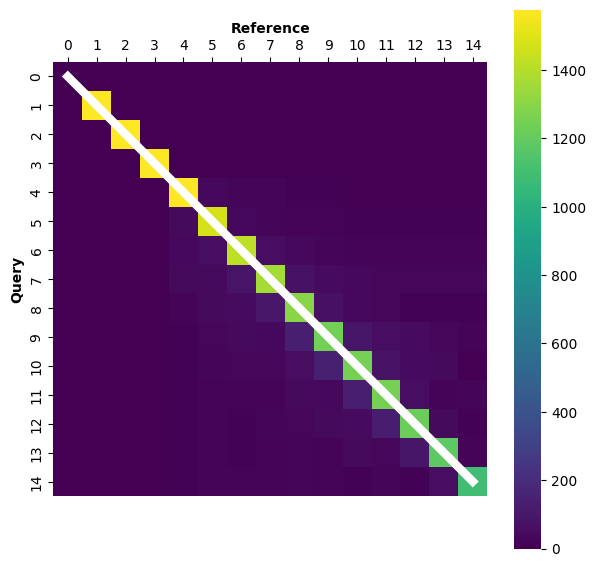

In [19]:
aligner.get_aggregate_alignment() 
plt.savefig(f'aggregate_alignment_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')
# Note: White path represents the average alignment path where diagonals represent matches; 
# vertical and horizontal paths could represent either warp matches or indels (mismatches)

In [20]:
plt.close('all')

## 3. Analysing gene-level alignments

Ranking genes based on their alignment similarities

Mean alignment similarity percentage (matched %): 
82.41000000000001 %


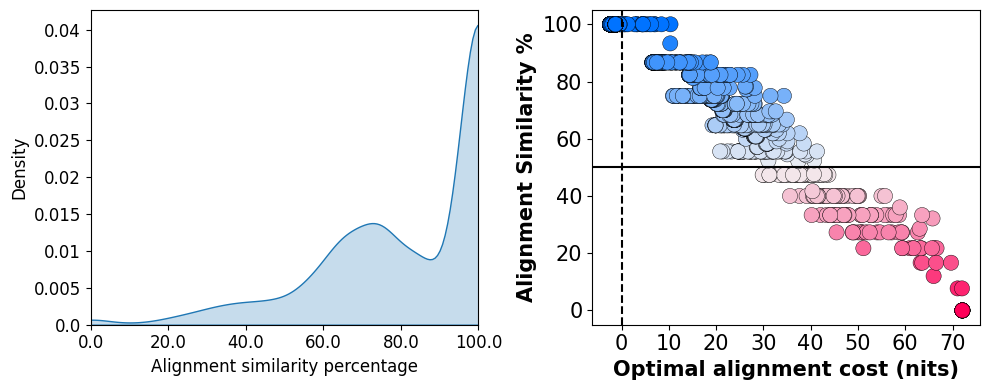

In [21]:
df = aligner.get_stat_df() # ordered genes according to alignment similarity statistics 
plt.savefig(f'ranking_genes_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

In [22]:
plt.close('all')

In [23]:
print(df)
print('Ten genes of the lowest similarity: ')
print(df['Gene'][1:10])
df.to_csv(f"ranking_genes__{prefix_ref}_vs_{prefix_query}.csv", index=False)

            Gene alignment_similarity_percentage opt_alignment_cost      l2fc  \
396   Ga04g00697                             0.0          72.073285      -inf   
1740  Ga01g01369                             0.0          72.073285       inf   
1738  Ga13g02330                             0.0          72.073285 -5.323707   
1339  Ga12g00233                             0.0          72.073285 -4.857996   
703   Ga07g01136                             0.0          72.073285 -4.034651   
...          ...                             ...                ...       ...   
1568  Ga05g01276                             1.0           -1.27971       NaN   
1638  Ga14g00988                             1.0           -1.27971       NaN   
1642  Ga13g00437                             1.0           -1.27971       NaN   
1682  Ga13g01221                             1.0           -1.27971       NaN   
1686  Ga13g01311                             1.0           -1.27971       NaN   

      color  abs_l2fc  
396

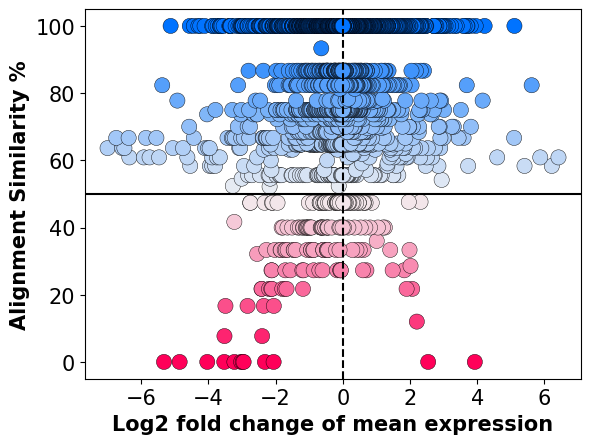

In [24]:
VisualUtils.plot_alignmentSim_vs_l2fc(df)
plt.savefig(f'ranking_genes_log2_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

In [25]:
plt.close('all')

A ranked list of genes based on their first match occurrence 

In [26]:
earliest_match_sorted_genes_list = aligner.show_ordered_alignments()

In the order of the first match occurrence along pseudotime
Gene        Alignment
----------  ----------------------------
Ga01g02207  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga02g00012  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga03g01437  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga04g00697  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga14g00277  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga07g01136  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga07g01598  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga08g02229  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga09g02383  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga11g01722  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga12g00054  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga12g00233  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga13g02330  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga01g01369  IIIDIDIDIDIIIIIIIIDDDDDDDDDD
Ga01g00084  MMMMMMMMMMMMMM
Ga01g00108  MMMMMMMMMMMMMM
Ga01g00176  MMMMMMMMMMMMMM
Ga01g00213  MMMMMMMMMMMMMM
Ga01g00241  MMMMMMMMMMMVVVDDD
Ga01g00261  MMMMMMMMMVVVVVDDDDD
Ga01g00286  MMMMMMMMMMMMMM
Ga01g00267  MMMMMMMMMMMMMM
Ga01g00274  MMMMMMMMMMMMMM
Ga01g00337  MMMMMMMMMMMMMM
Ga01g00362  MMMMMMMMMMMMM

## Gene-set overrepresentation analysis on the top dissimilar genes 

Checking top dissimilar genes, i.e, only <=30% similarity along pseudotime

In [27]:
threshold_similarity = 0.3
topDEgenes = df[df['alignment_similarity_percentage'] <= threshold_similarity]['Gene']
# print(topDEgenes); print(len(topDEgenes))
#可以做一个enrich看最不相似的基因主要富集到什么功能
os.makedirs("topDEgenes", exist_ok=True)
with open('topDEgenes/topDEgenes.txt', 'w') as f:
    for gene in topDEgenes[:10]:
        gene_obj = aligner.results_map[gene]
        alignment_str = gene_obj.alignment_str
        f.write(f'{gene} {alignment_str}\n')
        # 1) 打印对齐字符串和彩色版本
        print(alignment_str)
        print(VisualUtils.color_al_str(alignment_str))
        print()
        print(gene_obj.al_visual)
        # 2) 画 alignment landscape
        gene_obj.landscape_obj.plot_alignment_landscape()
        plt.savefig(
            f'topDEgenes/plot_cost_{gene}_{prefix_ref}_vs_{prefix_query}.pdf',
            bbox_inches='tight'
        )
        plt.close('all')
        # 3) 画 time series（带细胞）
        VisualUtils.plotTimeSeries(gene, aligner, plot_cells=True)
        plt.savefig(
            f'topDEgenes/plotTimeSeries_{gene}_{prefix_ref}_vs_{prefix_query}.pdf',
            bbox_inches='tight'
        )
        plt.close('all')

IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


IIIDIDIDIDIIIIIIIIDDDDDDDDDD
IIIDIDIDIDIIIIIIIIDDDDDDDDDD

0123456789012345678901234567 Alignment index 
   0 1 2 3        4567890123 Reference index
---*-*-*-*--------**********
***-*-*-*-********----------
012 3 4 5 67890123           Query index
IIIDIDIDIDIIIIIIIIDDDDDDDDDD 5-state string 


## Clustering alignments 

Running experiment to determine the distance threshold for alignment clusters from hierarchical clustering. We aim to select a locally optimal threshold that gives a good trade-off between high mean Silhouette score and low number of clusters which can be biologically meaningful. 

----------------------------3. Clustering alignments ---------------------
Compute distance matrix
- using levenshtein distance metric


Experimental mode: exploring different thresholds


  0%|                                                                                                                                             | 0/99 [00:00<?, ?it/s]

  1%|█▎                                                                                                                                   | 1/99 [00:00<00:54,  1.81it/s]

  2%|██▋                                                                                                                                  | 2/99 [00:01<00:51,  1.87it/s]

  3%|████                                                                                                                                 | 3/99 [00:01<00:54,  1.77it/s]

  4%|█████▎                                                                                                                               | 4/99 [00:02<00:52,  1.82it/s]

  5%|██████▋                                                                                                                              | 5/99 [00:02<00:50,  1.85it/s]

  6%|████████                                                                                                                             | 6/99 [00:03<00:50,  1.86it/s]

  7%|█████████▍                                                                                                                           | 7/99 [00:03<00:49,  1.87it/s]

  8%|██████████▋                                                                                                                          | 8/99 [00:04<00:48,  1.88it/s]

  9%|████████████                                                                                                                         | 9/99 [00:04<00:47,  1.89it/s]

 10%|█████████████▎                                                                                                                      | 10/99 [00:05<00:46,  1.89it/s]

 11%|██████████████▋                                                                                                                     | 11/99 [00:05<00:46,  1.90it/s]

 12%|████████████████                                                                                                                    | 12/99 [00:06<00:45,  1.90it/s]

 13%|█████████████████▎                                                                                                                  | 13/99 [00:06<00:45,  1.91it/s]

 14%|██████████████████▋                                                                                                                 | 14/99 [00:07<00:44,  1.91it/s]

 15%|████████████████████                                                                                                                | 15/99 [00:07<00:44,  1.90it/s]

 16%|█████████████████████▎                                                                                                              | 16/99 [00:08<00:43,  1.89it/s]

 17%|██████████████████████▋                                                                                                             | 17/99 [00:09<00:43,  1.89it/s]

 18%|████████████████████████                                                                                                            | 18/99 [00:09<00:42,  1.89it/s]

 19%|█████████████████████████▎                                                                                                          | 19/99 [00:10<00:42,  1.88it/s]

 20%|██████████████████████████▋                                                                                                         | 20/99 [00:10<00:41,  1.89it/s]

 21%|████████████████████████████                                                                                                        | 21/99 [00:11<00:40,  1.91it/s]

 22%|█████████████████████████████▎                                                                                                      | 22/99 [00:11<00:40,  1.92it/s]

 23%|██████████████████████████████▋                                                                                                     | 23/99 [00:12<00:39,  1.92it/s]

 24%|████████████████████████████████                                                                                                    | 24/99 [00:12<00:38,  1.93it/s]

 25%|█████████████████████████████████▎                                                                                                  | 25/99 [00:13<00:38,  1.92it/s]

 26%|██████████████████████████████████▋                                                                                                 | 26/99 [00:13<00:37,  1.92it/s]

 27%|████████████████████████████████████                                                                                                | 27/99 [00:14<00:37,  1.92it/s]

 28%|█████████████████████████████████████▎                                                                                              | 28/99 [00:14<00:36,  1.93it/s]

 29%|██████████████████████████████████████▋                                                                                             | 29/99 [00:15<00:36,  1.93it/s]

 30%|████████████████████████████████████████                                                                                            | 30/99 [00:15<00:35,  1.93it/s]

 31%|█████████████████████████████████████████▎                                                                                          | 31/99 [00:16<00:35,  1.93it/s]

 32%|██████████████████████████████████████████▋                                                                                         | 32/99 [00:16<00:34,  1.93it/s]

 33%|████████████████████████████████████████████                                                                                        | 33/99 [00:17<00:34,  1.94it/s]

 34%|█████████████████████████████████████████████▎                                                                                      | 34/99 [00:17<00:33,  1.93it/s]

 35%|██████████████████████████████████████████████▋                                                                                     | 35/99 [00:18<00:33,  1.94it/s]

 36%|████████████████████████████████████████████████                                                                                    | 36/99 [00:18<00:32,  1.94it/s]

 37%|█████████████████████████████████████████████████▎                                                                                  | 37/99 [00:19<00:32,  1.94it/s]

 38%|██████████████████████████████████████████████████▋                                                                                 | 38/99 [00:19<00:31,  1.94it/s]

 39%|████████████████████████████████████████████████████                                                                                | 39/99 [00:20<00:30,  1.94it/s]

 40%|█████████████████████████████████████████████████████▎                                                                              | 40/99 [00:20<00:30,  1.93it/s]

 41%|██████████████████████████████████████████████████████▋                                                                             | 41/99 [00:21<00:29,  1.93it/s]

 42%|████████████████████████████████████████████████████████                                                                            | 42/99 [00:22<00:29,  1.93it/s]

 43%|█████████████████████████████████████████████████████████▎                                                                          | 43/99 [00:22<00:28,  1.93it/s]

 44%|██████████████████████████████████████████████████████████▋                                                                         | 44/99 [00:23<00:28,  1.94it/s]

 45%|████████████████████████████████████████████████████████████                                                                        | 45/99 [00:23<00:27,  1.93it/s]

 46%|█████████████████████████████████████████████████████████████▎                                                                      | 46/99 [00:24<00:27,  1.93it/s]

 47%|██████████████████████████████████████████████████████████████▋                                                                     | 47/99 [00:24<00:26,  1.93it/s]

 48%|████████████████████████████████████████████████████████████████                                                                    | 48/99 [00:25<00:26,  1.93it/s]

 49%|█████████████████████████████████████████████████████████████████▎                                                                  | 49/99 [00:25<00:25,  1.93it/s]

 51%|██████████████████████████████████████████████████████████████████▋                                                                 | 50/99 [00:26<00:25,  1.93it/s]

 52%|████████████████████████████████████████████████████████████████████                                                                | 51/99 [00:26<00:25,  1.85it/s]

 53%|█████████████████████████████████████████████████████████████████████▎                                                              | 52/99 [00:27<00:25,  1.87it/s]

 54%|██████████████████████████████████████████████████████████████████████▋                                                             | 53/99 [00:27<00:24,  1.89it/s]

 55%|████████████████████████████████████████████████████████████████████████                                                            | 54/99 [00:28<00:23,  1.90it/s]

 56%|█████████████████████████████████████████████████████████████████████████▎                                                          | 55/99 [00:28<00:23,  1.91it/s]

 57%|██████████████████████████████████████████████████████████████████████████▋                                                         | 56/99 [00:29<00:22,  1.91it/s]

 58%|████████████████████████████████████████████████████████████████████████████                                                        | 57/99 [00:29<00:21,  1.92it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                      | 58/99 [00:30<00:21,  1.92it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▋                                                     | 59/99 [00:30<00:20,  1.92it/s]

 61%|████████████████████████████████████████████████████████████████████████████████                                                    | 60/99 [00:31<00:20,  1.92it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                  | 61/99 [00:31<00:19,  1.92it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                 | 62/99 [00:32<00:19,  1.93it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████                                                | 63/99 [00:32<00:18,  1.93it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                              | 64/99 [00:33<00:19,  1.81it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▋                                             | 65/99 [00:34<00:19,  1.73it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████                                            | 66/99 [00:34<00:18,  1.78it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                          | 67/99 [00:35<00:17,  1.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                          | 67/99 [00:35<00:16,  1.89it/s]

-- Cluster diagnostic plots


Potential candidates for distance threshold: a locally optimal thresholds that gives a good trade-off between high mean Silhouette score and low number of clusters 


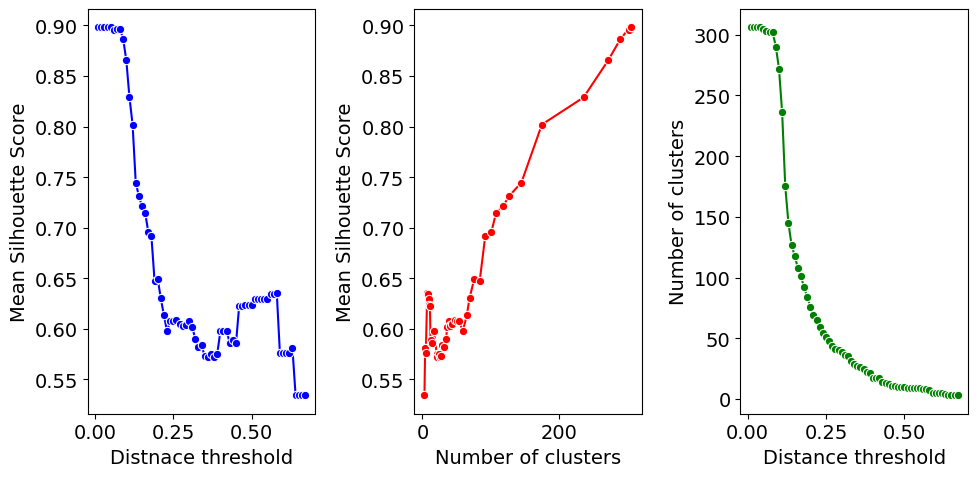

In [28]:
# ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.37) 
print('----------------------------3. Clustering alignments ---------------------')
df = ClusterUtils.run_clustering(aligner, metric='levenshtein', experiment_mode=True)
plt.savefig(f'clustering_genes_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

Run clustering with the chosen distance threshold. In this case we select 0.37

In [29]:
plt.close('all')

Visualise gene alignment grouped together in each cluster <br>
Note: diagonals represent matches; vertical and horizontal paths could represent either warp matches or indels (mismatches)

Compute distance matrix
- using levenshtein distance metric


run agglomerative clustering | distance threshold = 0.55


silhouette_score:  0.629449675619639


Cluster ID | Number of genes in the cluster


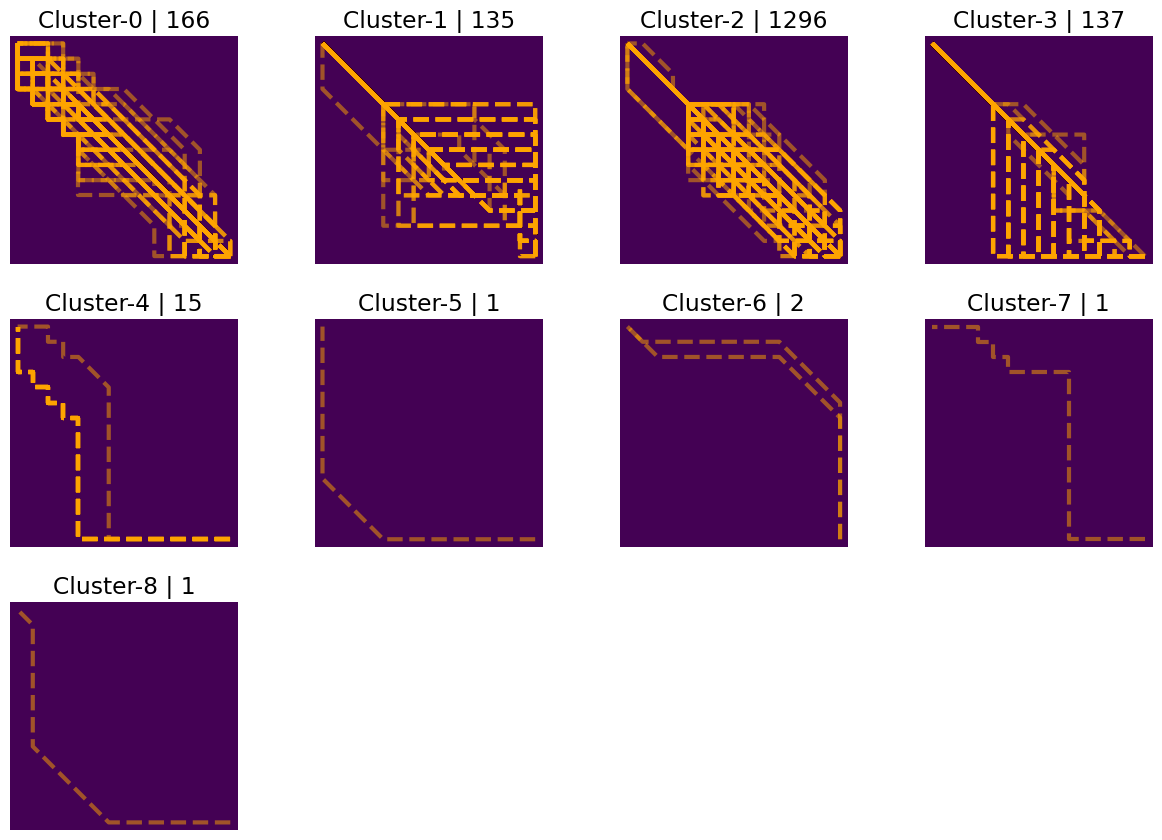

In [30]:
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=distance_threshold)
ClusterUtils.visualise_clusters(aligner,n_cols = 4, figsize= (5,3))
plt.savefig(f'clustering_genes_{distance_threshold}_{prefix_ref}_vs_{prefix_query}.pdf', bbox_inches='tight')

Visualise the distance matrix used in the clustering 

In [31]:
plt.close('all')

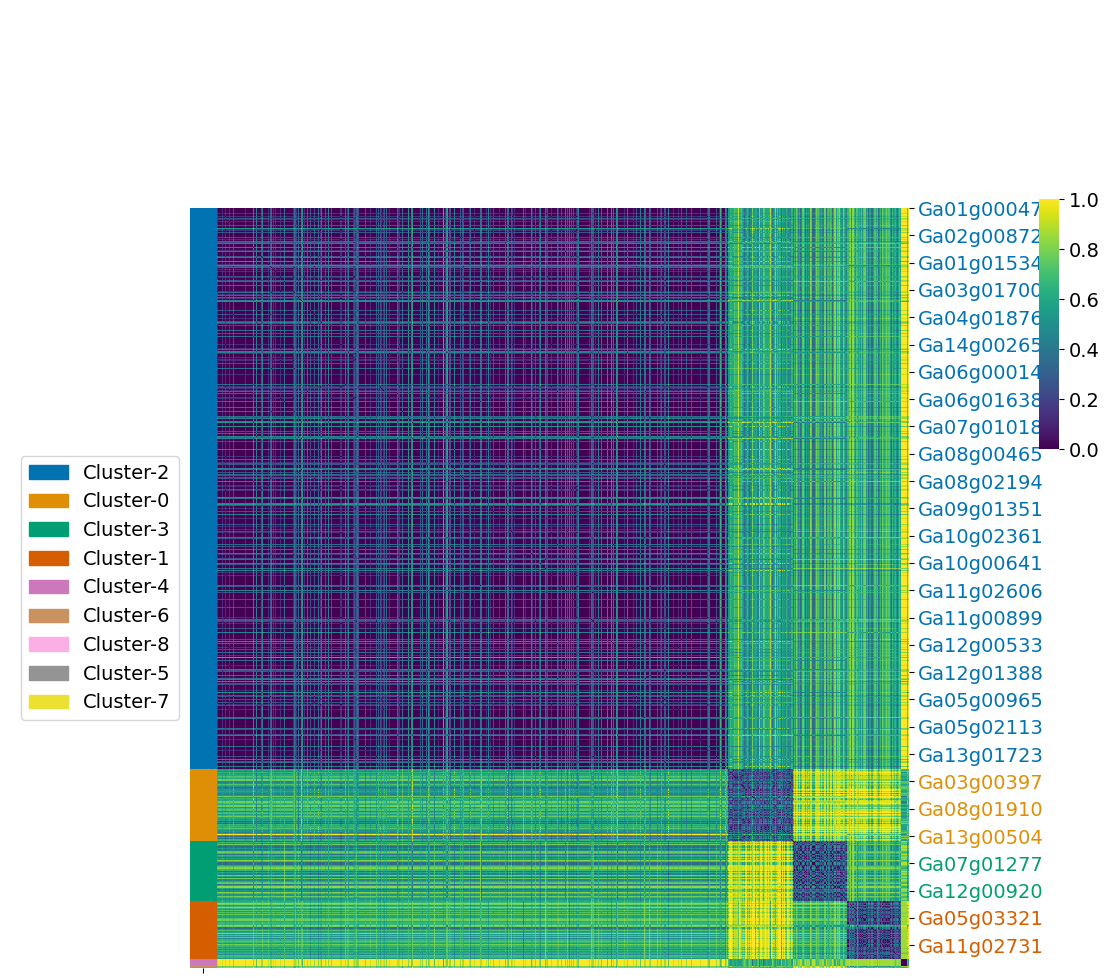

In [32]:
VisualUtils.plot_distmap_with_clusters(aligner)
plt.savefig(
    f'clustering_distmap_{distance_threshold}_{prefix_ref}_vs_{prefix_query}.png',
    bbox_inches='tight',
    dpi=72          # 清晰度够用且文件小；再降可改成 100 或 72
)

In [33]:
plt.close('all')

In [34]:
# ClusterUtils.print_cluster_average_alignments(aligner)
def get_cluster_average_alignments(aligner, gene_set, deterministic=True):
            cluster_alobjs = []
            for g in gene_set:
                cluster_alobjs.append(aligner.results_map[g])
            i = aligner.results[0].fwd_DP.T_len
            j = aligner.results[0].fwd_DP.S_len
            avg_alignment = ''
            tracked_path = []
            tracked_path.append([i,j])
            while(True):
                if(i==0 and j==0):
                    break
                backtrack_states_probs = {}
                backtrack_states_probs['M'] = 0 
                backtrack_states_probs['W'] = 0 
                backtrack_states_probs['V'] = 0 
                backtrack_states_probs['D'] = 0 
                backtrack_states_probs['I'] = 0 
                # record the count of each state at this [i,j] cell across all alignments 
                for a in cluster_alobjs:
                    backtract_state = a.landscape_obj.L_matrix_states[i,j]
                    if(backtract_state=='0'):
                        backtrack_states_probs['M']+=1 
                    elif(backtract_state=='1'):
                        backtrack_states_probs['W']+=1 
                    elif(backtract_state=='2'):
                        backtrack_states_probs['V']+=1 
                    elif(backtract_state=='3'):
                        backtrack_states_probs['D']+=1 
                    elif(backtract_state=='4'):
                        backtrack_states_probs['I']+=1 
                # compute the proportion of the state for the [i,j] cell
                for state in backtrack_states_probs.keys(): 
                    backtrack_states_probs[state] = backtrack_states_probs[state]/len(cluster_alobjs) 
                if(deterministic):
                    # take the most probable state based on max frequent state of this [i,j] cell
                    cs = np.argmax(np.asarray(list(backtrack_states_probs.values())) )
                else:
                    # sample a state from the state frequency distribution
                    cs = Utils.sample_state(np.asarray(list(backtrack_states_probs.values()) ) )
                if(cs==0):
                    i = i-1
                    j = j-1
                    avg_alignment = 'M' + avg_alignment 
                elif(cs==1 or cs==3):
                    j= j-1
                    if(cs==1):
                        avg_alignment = 'W' + avg_alignment
                    else:
                        avg_alignment = 'D' + avg_alignment
                elif(cs==2 or cs==4):
                    i=i-1
                    if(cs==2):
                        avg_alignment = 'V' + avg_alignment
                    else:
                        avg_alignment = 'I' + avg_alignment
                tracked_path.append([i,j])
            return avg_alignment, tracked_path

def print_cluster_average_alignments(aligner):
    aligner.gene_clusters_average_alignments = {}
    for i in range(len(aligner.gene_clusters)):
        average_alignment, avg_path =  get_cluster_average_alignments(aligner, aligner.gene_clusters[i] )
        print('cluster: ', i, average_alignment, '(',len(aligner.gene_clusters[i]), 'genes)')
        aligner.gene_clusters_average_alignments[i] = average_alignment


print_cluster_average_alignments(aligner)

# # To access the genes in a particular cluster
# cluster_id = 0
# print(aligner.gene_clusters[cluster_id]) 

# # To print all gene alignments in the cluster
# aligner.show_cluster_alignment_strings(cluster_id)

# ---------------- Clustering genes with df -----
records = []
for cluster_id, gene_list in aligner.gene_clusters.items():
    for gene in gene_list:
        gene_obj   = aligner.results_map[gene]
        alignment  = gene_obj.alignment_str
        records.append({
            'gene': gene,
            'cluster': cluster_id,
            'alignment': alignment
        })

df = pd.DataFrame(records)      # 三列：gene、cluster、alignment
print(df.head())
df.to_csv('gene_cluster_alignment.csv', sep='\t', index=False)

cluster:  0 IIIDIDIDDDMMMMMMMMID ( 166 genes)
cluster:  1 MMMMMMMWWWWWWWIIIIIII ( 135 genes)
cluster:  2 MMMMMMMMMMMMMM ( 1296 genes)
cluster:  3 MMMMMMMMVVVVVVDDDDDD ( 137 genes)
cluster:  4 IIIDIDIDIDIIIIIIIIDDDDDDDDDD ( 15 genes)
cluster:  5 IIIDIDIIIIIIMMMMWWWWWWWW ( 1 genes)
cluster:  6 MMWWWWWWDDMMMMIIIIIIII ( 2 genes)
cluster:  7 IIIDIDIDIDDDDDMVVVVVVIDDDDD ( 1 genes)
cluster:  8 MVVVVVVVIMMMMMDDDDDDDD ( 1 genes)
         gene  cluster        alignment
0  Ga01g00047        2  MMMMMMMMIDMMMMM
1  Ga01g00084        2   MMMMMMMMMMMMMM
2  Ga01g00108        2   MMMMMMMMMMMMMM
3  Ga01g00176        2   MMMMMMMMMMMMMM
4  Ga01g00213        2   MMMMMMMMMMMMMM


Print the aggregate (average) cell-level alignments for each cluster

In [35]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IIIDIDIDDDMMMMMMMMID ( 166 genes)
cluster:  1 MMMMMMMWWWWWWWIIIIIII ( 135 genes)
cluster:  2 MMMMMMMMMMMMMM ( 1296 genes)
cluster:  3 MMMMMMMMVVVVVVDDDDDD ( 137 genes)
cluster:  4 IIIDIDIDIDIIIIIIIIDDDDDDDDDD ( 15 genes)
cluster:  5 IIIDIDIIIIIIMMMMWWWWWWWW ( 1 genes)
cluster:  6 MMWWWWWWDDMMMMIIIIIIII ( 2 genes)
cluster:  7 IIIDIDIDIDDDDDMVVVVVVIDDDDD ( 1 genes)
cluster:  8 MVVVVVVVIMMMMMDDDDDDDD ( 1 genes)


In [36]:
# # To access the genes in a particular cluster
# cluster_id = 0
# print(aligner.gene_clusters[cluster_id]) 

# # To print all gene alignments in the cluster
# aligner.show_cluster_alignment_strings(cluster_id)

In [37]:
# ------------------ subset ------
os.makedirs("cluster", exist_ok=True)
for cluster in df['cluster'].unique():
    print(f"Subset: {cluster}")
    GENE_SUBSET = df[df['cluster'] == cluster]['gene']
    # Average alignment of any given subset of genes
    aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)
    plt.savefig(
        f'cluster/aggregate_alignment_{cluster}_{prefix_ref}_vs_{prefix_query}.pdf',
        bbox_inches='tight'
    )
    plt.close('all')

Subset: 2
Average Alignment:  MMMMMMMMMMMMMM (cell-level)


Subset: 0
Average Alignment:  IIIDIDIDDDMMMMMMMMID (cell-level)


Subset: 3
Average Alignment:  MMMMMMMMVVVVVVDDDDDD (cell-level)


Subset: 1
Average Alignment:  MMMMMMMWWWWWWWIIIIIII (cell-level)


Subset: 4
Average Alignment:  IIIDIDIDIDIIIIIIIIDDDDDDDDDD (cell-level)


Subset: 6
Average Alignment:  MMWWWWWWDDMMMMIIIIIIII (cell-level)


Subset: 7
Average Alignment:  IIIDIDIDIDDDDDMVVVVVVIDDDDD (cell-level)


Subset: 5
Average Alignment:  IIIDIDIIIIIIMMMMWWWWWWWW (cell-level)


Subset: 8
Average Alignment:  MVVVVVVVIMMMMMDDDDDDDD (cell-level)


In [38]:
# # To get the cluster id of an alignment object, e.g. TNF, 
# aligner.results_map['Ga01g01085'].cluster_id

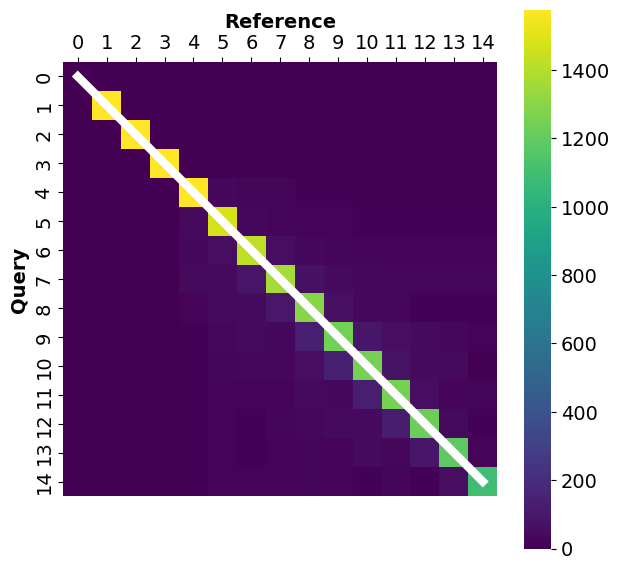

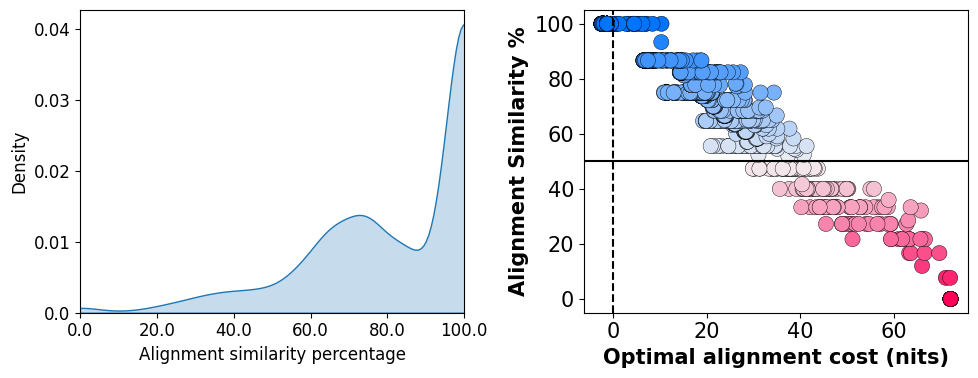

In [39]:
# ----------------------- Save log.txt ---------------------
import sys
from contextlib import redirect_stdout

# 打开一个追加模式文件
log_file = open('log.txt', 'a', buffering=1)  # buffering=1 行缓冲，实时写盘
with redirect_stdout(log_file):
    aligner.get_aggregate_alignment()
    print()
    df = aligner.get_stat_df()
    print()
    print_cluster_average_alignments(aligner)
    


log_file.close()

In [40]:
# ---------------------- How to save aligner file? -------------
import pickle

with open(f'aligner_{prefix_ref}_vs_{prefix_query}.pkl', 'wb') as f:
    pickle.dump(aligner, f)
    
# with open('aligner.pkl', 'rb') as f:
#     aligner = pickle.load(f)

### Average alignment of any given subset of genes 
e.g. `gene_list[40:60]` or a specific gene set in a specific pathway, e.g. EMT

In [41]:
# GENE_SUBSET = gene_list[40:60]
# aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)

###  Exploring alignment and trends of a given gene set

Following calls a wrapper to extract a specified pathway gene set from msigdb database via blitzgsea package (https://github.com/MaayanLab/blitzgsea) 

In [42]:
# IGS = PathwayAnalyser.InterestingGeneSets(gene_list) 
# #IGS.get_available_pathway_list('KEGG_2021_Human')
# #IGS.get_available_pathway_list('MSigDB_Hallmark_2020')

You could also add a new library by calling below. <br>

In [43]:
# ===== Check available libraries in enrichr

#import blitzgsea
#blitzgsea.enrichr.print_libraries()

# ===== Add a selected library

#library_name = "GO_Molecular_Function_2021"
#IGS.add_library(blitzgsea.enrichr.get_library(library_name), library_name)

#### Check the aggregate alignment and interpolated gene expression trends for a given pathway gene set as below. 

In [44]:
# IGS.add_new_set_from_msigdb('MSigDB_Hallmark_2020', 'Epithelial Mesenchymal Transition', user_setname='EMT') 

In [45]:
# PathwayAnalyser.get_pathway_alignment_stat(aligner, IGS.SETS['EMT'], 'EMT', cluster=True, FIGSIZE=(3,6))

In [46]:
# PathwayAnalyser.get_pathway_alignment_stat(aligner, gene_list[0:20], 'EMT', cluster=True, FIGSIZE=(3,6))